# 1: Import

In [1]:
is_google_colab = False

## 1.1 Mount Drive

In [2]:
if is_google_colab:
    from google.colab import drive
    drive.mount('/content/drive')

## 1.2: Pip install

In [3]:
# Standard libraries (usually pre-installed with Python, but in case of a clean environment)
!pip install numpy
!pip install pandas
!pip install scipy

# Preprocessing and Machine Learning utilities
!pip install scikit-learn

# Model serialization
!pip install joblib

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


## 1.3: Libraries

In [3]:
import pickle
import numpy as np
import pandas as pd
from scipy import stats
import joblib
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score, roc_auc_score,
    confusion_matrix, matthews_corrcoef, balanced_accuracy_score, roc_curve, auc
)

## 1.4 Functions

In [4]:
def convert_columns_to_int(df, column_names):
    """
    Convert specified columns in a DataFrame to integers after replacing commas with dots.

    Parameters:
        df (DataFrame): The DataFrame containing the columns to be converted.
        column_names (list): A list of column names to be converted.

    Returns:
        DataFrame: The DataFrame with specified columns converted to integers.
    """
    for column_name in column_names:
        # Replace commas with dots
        df[column_name] = df[column_name].str.replace(',', '.')

        # Convert the column to float first, to handle decimal values properly
        df[column_name] = df[column_name].astype(float)

    return df

def remove_rows_with_high_zscores(df, feature_list, z_threshold=3):
    # Calculate Z-Scores for the specified features
    z_scores_df = df[feature_list].apply(lambda x: np.abs(stats.zscore(x)))

    # Identify rows where the Z-Score is greater than or equal to the threshold for any feature
    high_z_scores = (z_scores_df >= z_threshold).any(axis=1)

    # Filter out rows with high Z-Scores
    filtered_df = df[~high_z_scores]

    # Optional: Print the number of rows removed
    num_removed = df.shape[0] - filtered_df.shape[0]
    print(f"Number of rows removed: {num_removed} ({(num_removed / df.shape[0]) * 100:.2f}%)")

    return filtered_df

def aspect_direction_NESW(aspect):
    if aspect == -1:
        return 'Flat'
    elif 0 <= aspect < 45 or 315 <= aspect <= 360:
        return 'North'
    elif 45 <= aspect < 135:
        return 'East'
    elif 135 <= aspect < 225:
        return 'South'
    elif 225 <= aspect < 315:
        return 'West'


def aspect_direction_NS(aspect):
    if aspect == -1:
        return 'Flat'
    elif 0 <= aspect < 90 or 270 <= aspect <= 360:
        return 'North'
    elif 90 <= aspect < 270:
        return 'South'

def calculate_vegetation_indices(df, blue_band, green_band, red_band, red_edge_band, nir_band, swir1_band, swir2_band):
    """
    Calculate vegetation indices and add them as new features to the DataFrame.

    Parameters:
    - df (DataFrame): DataFrame containing satellite data with red, near-infrared, infrared, and green bands.
    - red_band (str): Name of the column representing the red band (Band 4).
    - nir_band (str): Name of the column representing the near-infrared band (Band 8).
    - blue_band (str): Name of the column representing the blue band (Band 2).
    - green_band (str): Name of the column representing the green band (Band 3).
    - L (float): Parameter for the SAVI and OSAVI indices, default value is 0.5.

    Returns:
    - df_with_indices (DataFrame): DataFrame with additional columns for vegetation indices.
    """

    EPS = 1e-10

    # NDVI (Normalized Difference Vegetation Index)
    df['NDVI'] = (df[nir_band] - df[red_band]) / (df[nir_band] + df[red_band] + EPS)

    # NDRE (Normalized Difference Red Edge)
    df['NDRE'] = (df[nir_band] - df[red_edge_band]) / (df[nir_band] + df[red_edge_band] + EPS)

    # NDWI (Normalized Difference Water Index)
    df['NDWI'] = (df[green_band] - df[nir_band]) / (df[green_band] + df[nir_band] + EPS)

    # EVI (Enhanced Vegetation Index)
    df['EVI'] = (2.5 * df[nir_band] - df[red_band]) / ((df[nir_band] + 6 * df[red_band]) - (7.5 * df[blue_band] + 1) + EPS)

    # LCI (Leaf Chlorophyll Index)
    df['LCI'] = (df[nir_band] - df[red_edge_band]) / (df[nir_band] + df[red_band] + EPS)

    # CVI (Chlorophyll Vegetation Index)
    df['CVI'] = (df[nir_band] * df[red_band]) / ((df[green_band] ** 2) + EPS)

    # GCI (Green Chlorophyll Index)
    df['GCI'] = (df[nir_band] / (df[green_band] + EPS)) - 1

    # ARI (Anthocyanin Reflectance Index)
    df['ARI'] = (1 / (df[green_band] + EPS)) - (1 / (df[red_edge_band] + EPS))

    # MSAVI2 (Modified Soil-Adjusted Vegetation Index 2)
    df['MSAVI2'] = (2 * df[nir_band] + 1 - np.sqrt(np.maximum((((2 * df[nir_band] + 1)**2) - (8*(df[nir_band] - df[red_band]))), 0))) / 2

    # BSI (Bare Soil Index)
    df['BSI'] = ((df[red_band]+df[swir1_band]) - (df[nir_band]+df[blue_band])) / ((df[red_band]+df[swir1_band]) + (df[nir_band]+df[blue_band]) + EPS)

    # NDMI (Normalized Difference Moisture Index)
    df['NDMI'] = (df[nir_band] - df[swir1_band]) / (df[nir_band] + df[swir1_band] + EPS)

    # NBR (Normalized Burn Ratio)
    df['NBR'] = (df[nir_band] - df[swir2_band]) / (df[nir_band] + df[swir2_band] + EPS)

    # NDSI (Normalized Difference Soil Index)
    df['NDSI'] = (df[green_band] - df[swir1_band]) / (df[green_band] + df[swir1_band] + EPS)

    return df

In [5]:
def process_wildfire_data(df_original, has_outliers=True, aspect_info='none', subset='subset_1'):
    """
    Process the input DataFrame based on outlier handling, aspect information, and the subset type.

    Parameters:
        df_original (DataFrame): The original DataFrame to process.
        has_outliers (bool): Whether to process data with outliers or not.
        aspect_info (str): 'none', 'NESW', or 'NS' for aspect information.
        subset (str): 'subset_1' or 'subset_2' based on the subset type.

    Returns:
        DataFrame: Processed DataFrame according to the parameters.
    """
    
    # Step 1: Data Cleaning and Preprocessing
    # Copy df_original to ensure we don't modify it directly
    df_clean = df_original.copy(deep=True)

    # Convert 'Aspect' column to integer-like format
    df_clean = convert_columns_to_int(df_clean, ['Elevation', 'Aspect', 'Slope', 'POINT_X', 'POINT_Y', 'POINT_Z'])

    # Replace NaN values with appropriate defaults
    df_clean['Elevation'] = df_clean['Elevation'].fillna(0)  # NaN Elevation replaced with 0 (sea level)
    df_clean['Slope'] = df_clean['Slope'].fillna(0)          # NaN Slope replaced with 0 (sea level)
    df_clean['Aspect'] = df_clean['Aspect'].fillna(-1)       # NaN Aspect replaced with -1 (indicating flat sea)


    # Step 2: Feature Engineering
    # Add aspect direction features
    df_clean['Aspect_Text_NESW'] = df_clean['Aspect'].apply(aspect_direction_NESW)
    df_clean['Aspect_Text_NS'] = df_clean['Aspect'].apply(aspect_direction_NS)

    # Calculate vegetation indices
    df_clean = calculate_vegetation_indices(df_clean, 'B02', 'B03', 'B04', 'B05', 'B08', 'B11', 'B12')

    # Drop unnecessary columns
    columns_to_drop = ['Aspect', 'COS18n1_C', 'COS18n1_L']
    df_clean = df_clean.drop(columns=columns_to_drop)


    # Step 3: Drop highly correlated or uncorrelated features
    if subset == 'subset_1':
        columns_to_drop_subset = {
            True: ['B02', 'B05', 'B07', 'B08', 'B11', 'NDRE', 'LCI', 'NDMI', 'CVI', 'ARI', 'NDSI', 'EVI'],  # With outliers
            False: ['B02', 'B05', 'B07', 'B08', 'B11', 'NDVI', 'NDRE', 'LCI', 'NDMI', 'CVI', 'NDSI', 'EVI'] # No outliers
        }
    else:
        columns_to_drop_subset = {
            True: ['B02', 'B03', 'B05', 'B06', 'B08', 'B11', 'Elevation', 'Slope', 'NDVI', 'NDRE', 'LCI', 'GCI', 'NBR', 'NDMI', 'BSI', 'CVI', 'EVI'],         # With outliers
            False: ['B02', 'B03', 'B05', 'B07', 'B08', 'B11', 'Elevation', 'Slope', 'NDVI', 'NDRE', 'LCI', 'GCI', 'NBR', 'NDMI', 'BSI', 'ARI', 'CVI', 'EVI']  # No outliers
        }

    df_clean = df_clean.drop(columns=columns_to_drop_subset[has_outliers])


    # Step 4: One-Hot Encoding for categorical variables
    df_clean = pd.get_dummies(df_clean, columns=['Aspect_Text_NESW', 'Aspect_Text_NS'])


    # Step 5: Handle Aspect Information
    columns_to_drop_NESW = ['Aspect_Text_NESW_East', 'Aspect_Text_NESW_Flat', 'Aspect_Text_NESW_North', 'Aspect_Text_NESW_South', 'Aspect_Text_NESW_West']
    columns_to_drop_NS = ['Aspect_Text_NS_Flat', 'Aspect_Text_NS_North', 'Aspect_Text_NS_South']

    if aspect_info == 'none':
        df_clean_no_aspect = df_clean.drop(columns=columns_to_drop_NESW + columns_to_drop_NS)
        return df_clean_no_aspect
    elif aspect_info == 'NESW':
        df_clean_NESW = df_clean.drop(columns=columns_to_drop_NS)
        return df_clean_NESW
    elif aspect_info == 'NS':
        df_clean_NS = df_clean.drop(columns=columns_to_drop_NESW)
        return df_clean_NS

    return df_clean

In [6]:
def calculate_percentage(series, perc=0.4):
    """
    Calculate the percentage of records in a series that are above or equal to a given threshold.

    Parameters:
    series (pd.Series): The data series to evaluate.
    perc (float): The threshold percentage value.

    Returns:
    float: The percentage of records that are above or equal to the given threshold.
    """
    total_records = len(series)
    if total_records == 0:
        return 0
    above_perc = len(series[series >= perc])
    above_perc = (above_perc / total_records) * 100
    return above_perc

In [7]:
def calculate_metrics_with_plots(
    df, prob_column, true_label_column, threshold=0.4, plot_title="Model Performance"
):
    # Apply the threshold to make predictions
    predictions = (df[prob_column] >= threshold).astype(int)
    
    # Calculate confusion matrix components
    tn, fp, fn, tp = confusion_matrix(df[true_label_column], predictions).ravel()
    
    # Calculate metrics
    metrics = {
        'Accuracy': accuracy_score(df[true_label_column], predictions),
        'Balanced Accuracy': balanced_accuracy_score(df[true_label_column], predictions),
        'Recall': recall_score(df[true_label_column], predictions),
        'Precision': precision_score(df[true_label_column], predictions),
        'F1-Score': f1_score(df[true_label_column], predictions),
        'ROC-AUC': roc_auc_score(df[true_label_column], df[prob_column]),
        'Matthews Correlation Coefficient (MCC)': matthews_corrcoef(df[true_label_column], predictions),
        'True Positives (TP)': tp,
        'False Positives (FP)': fp,
        'True Negatives (TN)': tn,
        'False Negatives (FN)': fn,
        'Support (Total Positive)': tp + fn,
        'Support (Total Negative)': tn + fp,
    }
    
    # Generate ROC Curve
    fpr, tpr, thresholds = roc_curve(df[true_label_column], df[prob_column])
    auc_score = auc(fpr, tpr)
    
    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Chance')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f"{plot_title} - ROC Curve")
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()
    
    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(df[true_label_column], predictions)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Burned', 'Burned'], yticklabels=['Not Burned', 'Burned'])
    plt.title(f"{plot_title} - Confusion Matrix", fontsize=16)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()
    
    print("Complete Metric:")
    print(metrics)
    
    return metrics

In [8]:
def plot_confusion_matrix_from_aggregated_results(model_name, aggregated_results):
    # Filter the data for the given model
    model_data = aggregated_results[aggregated_results['Model'] == model_name].iloc[0]

    # Extract confusion matrix components
    tp = model_data['True Positives (TP)']
    tn = model_data['True Negatives (TN)']
    fp = model_data['False Positives (FP)']
    fn = model_data['False Negatives (FN)']

    # Create confusion matrix
    cm = [[tn, fp],
          [fn, tp]]

    # Plot the confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f"Confusion Matrix for {model_name}", fontsize=16)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

## 1.5 Models

In [9]:
if is_google_colab:
    path='/content/drive/MyDrive/Thesis/Python/'
else:
    path=''

In [10]:
# Load the model and the scaler
rf_model_1_df_subset_1_no_Aspect_final = joblib.load(path+'rf_model_1_df_subset_1_no_Aspect_final.pkl')
rf_model_2_df_subset_2_NESW_final = joblib.load(path+'rf_model_2_df_subset_2_NESW_final.pkl')
xgb_model_1_df_subset_1_no_outliers_no_Aspect_final = joblib.load(path+'xgb_model_1_df_subset_1_no_outliers_no_Aspect_final.pkl')
xgb_model_2_df_subset_2_no_outliers_no_Aspect_final = joblib.load(path+'xgb_model_2_df_subset_2_no_outliers_no_Aspect_final.pkl')
scaler_mlp_model_1_final = joblib.load(path+'scaler_mlp_model_1_df_subset_1_no_outliers_no_Aspect_final.pkl')
scaler_mlp_model_2_final = joblib.load(path+'scaler_mlp_model_2_df_subset_2_no_Aspect_final.pkl')
mlp_model_1_df_subset_1_no_outliers_no_Aspect_final = joblib.load(path+'mlp_model_1_df_subset_1_no_outliers_no_Aspect_final.pkl')
mlp_model_2_df_subset_2_no_Aspect_final = joblib.load(path+'mlp_model_2_df_subset_2_no_Aspect_final.pkl')

# 2: Datasets

## 2.1: 2023 05 11 - Subset 1

In [15]:
file_path_20230511 = path+'TestData_20230511_V2.csv'

# Read the CSV file into a DataFrame
df_original_20230511 = pd.read_csv(file_path_20230511, sep=';')
# df_original_20230511 = df_original_20230511.sort_values(by='point_ID')

In [16]:
# Define the columns to check
bands_columns = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B11', 'B12']
# Filter out rows where all specified bands are zero
df_original_20230511 = df_original_20230511[~(df_original_20230511[bands_columns].sum(axis=1) == 0)]

In [17]:
id_counts = df_original_20230511.groupby('point_ID').size().reset_index(name='count')
id_counts_more_than_one = id_counts[id_counts['count'] > 1]
id_counts_more_than_one.count()
duplicates = df_original_20230511[df_original_20230511['point_ID'].isin(id_counts_more_than_one['point_ID'])]
duplicates_sorted = duplicates.sort_values(by='point_ID')
indices_to_drop = duplicates_sorted.iloc[1::2].index
df_original_20230511 = df_original_20230511.drop(indices_to_drop)

# Display the DataFrame
df_original_20230511.sort_values(by='point_ID')

Burned   B02   B03   B04   B05   B06   B07   B08   B11   B12  \
7             0  1394  1415  1162  1155  1125  1107  1117  1117  1099   
8             0  1388  1394  1161  1151  1120  1112  1125  1113  1105   
12            0  1391  1410  1172  1151  1123  1107  1118  1116  1108   
13            0  1382  1399  1162  1142  1121  1109  1115  1116  1103   
14            0  1363  1386  1158  1148  1117  1114  1111  1112  1099   
...         ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
7954494       0  2022  2435  2978  3291  3501  3690  4022  5479  4373   
7954495       0  1972  2364  2838  3219  3423  3649  3956  5286  4211   
7954496       0  2040  2467  2935  3224  3552  3854  4081  5106  4070   
7954497       0  1863  2295  2638  3325  3808  4095  4317  5152  4008   
7954498       0  1932  2330  2920  3313  3662  3905  4400  5498  4180   

           Elevation      Slope       Aspect  point_ID                POINT_X  \
7                NaN        NaN          NaN         8  22842,053501153543039   
8                NaN        NaN          NaN         9  22862,058338648519566   
12               NaN        NaN          NaN        13  22842,235502027662733   
13               NaN        NaN          NaN        14  22862,240339517760731   
14               NaN        NaN          NaN        15  22882,245176244690811   
...              ...        ...          ...       ...                    ...   
7954494  150,7298889  4,2724419   99,5473404   7960603  76877,374185099033639   
7954495  148,7304230  3,8710780  101,3606949   7960604  76897,377005784932408   
7954496  147,2777100  2,9855778  108,8411331   7960605  76917,379825721902307   
7954497  146,1998901  2,8572645  120,3603058   7960606  76937,382644903074834   
7954498  145,1622467  3,0120704  114,3852158   7960607  76957,385463337981491   

                         POINT_Y            POINT_Z  COS18n1_C  \
7        -300847,306115729676094  0,000000000000000          9   
8        -300847,488116220687516  0,000000000000000          9   
12       -300827,301277856284287  0,000000000000000          9   
13       -300827,483279108768329  0,000000000000000          9   
14       -300827,665280355839059  0,000000000000000          9   
...                          ...                ...        ...   
7954494  -192094,375078866258264  0,000000000000000          4   
7954495  -192094,561202105367556  0,000000000000000          4   
7954496  -192094,747325348260347  0,000000000000000          4   
7954497  -192094,933448590774788  0,000000000000000          3   
7954498  -192095,119571833522059  0,000000000000000          3   

                                COS18n1_L  
7             Massas de água superficiais  
8             Massas de água superficiais  
12            Massas de água superficiais  
13            Massas de água superficiais  
14            Massas de água superficiais  
...                                   ...  
7954494  Superfícies agroflorestais (SAF)  
7954495  Superfícies agroflorestais (SAF)  
7954496  Superfícies agroflorestais (SAF)  
7954497                         Pastagens  
7954498                         Pastagens  

[7943946 rows x 19 columns]

In [18]:
# Count the number of 0s and 1s in the 'Burned' column
count_0 = (df_original_20230511['Burned'] == 0).sum()
count_1 = (df_original_20230511['Burned'] == 1).sum()

# Calculate the ratio of count_1 to count_0 as a percentage
ratio = (count_1 / count_0) * 100

# Print the counts and the ratio
print(f"Number of 0s: {count_0}")
print(f"Number of 1s: {count_1}")
print(f"Ratio of 1s to 0s: {ratio:.5f}%")

Number of 0s: 7935764
Number of 1s: 8182
Ratio of 1s to 0s: 0.10310%


In [19]:
df_original_20230511.describe(include='all').T

count   unique                      top     freq  \
Burned     7943946.0      NaN                      NaN      NaN   
B02        7943946.0      NaN                      NaN      NaN   
B03        7943946.0      NaN                      NaN      NaN   
B04        7943946.0      NaN                      NaN      NaN   
B05        7943946.0      NaN                      NaN      NaN   
B06        7943946.0      NaN                      NaN      NaN   
B07        7943946.0      NaN                      NaN      NaN   
B08        7943946.0      NaN                      NaN      NaN   
B11        7943946.0      NaN                      NaN      NaN   
B12        7943946.0      NaN                      NaN      NaN   
Elevation    7730238  4210045               47,5029984    16450   
Slope        7718298  4621461                0,0000000    22731   
Aspect       7718023  4473390               -1,0000000    22646   
point_ID   7943946.0      NaN                      NaN      NaN   
POINT_X      7943946  7943946    22842,053501153543039        1   
POINT_Y      7943946  7943946  -300847,306115729676094        1   
POINT_Z      7943946        1        0,000000000000000  7943946   
COS18n1_C  7943946.0      NaN                      NaN      NaN   
COS18n1_L    7943946        9                Florestas  2508022   

                     mean             std     min         25%        50%  \
Burned            0.00103        0.032077     0.0         0.0        0.0   
B02           1747.328058      274.091733  1005.0      1574.0     1720.0   
B03           2090.827316      355.479277  1017.0      1854.0     2055.0   
B04           2436.381581       548.99938  1017.0      2045.0     2415.0   
B05           2810.017358      551.136841   874.0      2447.0     2793.0   
B06           3255.447726      571.377529   675.0      2964.0     3256.0   
B07           3454.926023      619.660794   909.0      3141.0     3458.0   
B08           3693.038206      673.143588   753.0      3354.0     3699.0   
B11           4283.468471      882.868448   956.0      3815.0     4308.0   
B12           3362.647487       733.51566   986.0      2932.0     3373.0   
Elevation             NaN             NaN     NaN         NaN        NaN   
Slope                 NaN             NaN     NaN         NaN        NaN   
Aspect                NaN             NaN     NaN         NaN        NaN   
point_ID   3978092.274239  2294149.794018     8.0  1992546.25  3978715.5   
POINT_X               NaN             NaN     NaN         NaN        NaN   
POINT_Y               NaN             NaN     NaN         NaN        NaN   
POINT_Z               NaN             NaN     NaN         NaN        NaN   
COS18n1_C        4.484652        1.739526     1.0         3.0        5.0   
COS18n1_L             NaN             NaN     NaN         NaN        NaN   

                  75%        max  
Burned            0.0        1.0  
B02            1872.0    16715.0  
B03            2269.0    13096.0  
B04            2789.0    10678.0  
B05            3151.0    17126.0  
B06            3561.0    16323.0  
B07            3781.0    16820.0  
B08            4057.0    12630.0  
B11            4854.0    16144.0  
B12            3839.0    16086.0  
Elevation         NaN        NaN  
Slope             NaN        NaN  
Aspect            NaN        NaN  
point_ID   5964701.75  7960607.0  
POINT_X           NaN        NaN  
POINT_Y           NaN        NaN  
POINT_Z           NaN        NaN  
COS18n1_C         6.0        9.0  
COS18n1_L         NaN        NaN

In [20]:
# Prepare the data
RF_df_20230511_subset_1_with_outliers_no_Aspect = process_wildfire_data(df_original_20230511, has_outliers=True, aspect_info='none', subset='subset_1')
XGB_df_20230511_subset_1_no_outliers_no_Aspect = process_wildfire_data(df_original_20230511, has_outliers=False, aspect_info='none', subset='subset_1')
MLP_df_20230511_subset_1_no_outliers_no_Aspect = process_wildfire_data(df_original_20230511, has_outliers=False, aspect_info='none', subset='subset_1')

In [21]:
RF_df_20230511_subset_1_with_outliers_no_Aspect = RF_df_20230511_subset_1_with_outliers_no_Aspect.drop(columns=['point_ID', 'POINT_X', 'POINT_Y', 'POINT_Z', 'Burned'])
XGB_df_20230511_subset_1_no_outliers_no_Aspect = XGB_df_20230511_subset_1_no_outliers_no_Aspect.drop(columns=['point_ID', 'POINT_X', 'POINT_Y', 'POINT_Z', 'Burned'])
MLP_df_20230511_subset_1_no_outliers_no_Aspect = MLP_df_20230511_subset_1_no_outliers_no_Aspect.drop(columns=['point_ID', 'POINT_X', 'POINT_Y', 'POINT_Z', 'Burned'])

In [22]:
# For Random Forest: rf_model_1_df_subset_1_no_Aspect_final
df_original_20230511['RF_Prob'] = rf_model_1_df_subset_1_no_Aspect_final.predict_proba(RF_df_20230511_subset_1_with_outliers_no_Aspect)[:, 1]

# For XGBoost: xgb_model_1_df_subset_1_NESW_final
df_original_20230511['XGB_Prob'] = xgb_model_1_df_subset_1_no_outliers_no_Aspect_final.predict_proba(XGB_df_20230511_subset_1_no_outliers_no_Aspect)[:, 1]

# For MLP: mlp_model_1_df_subset_1_no_outliers_no_Aspect_final
MLP_df_20230511_subset_1_no_outliers_no_Aspect_scaled = scaler_mlp_model_1_final.transform(MLP_df_20230511_subset_1_no_outliers_no_Aspect)
df_original_20230511['MLP_Prob'] = mlp_model_1_df_subset_1_no_outliers_no_Aspect_final.predict_proba(MLP_df_20230511_subset_1_no_outliers_no_Aspect_scaled)[:, 1]

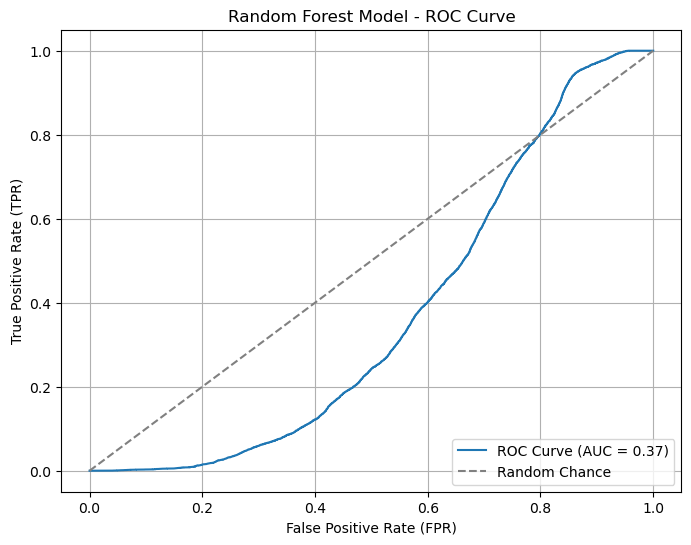

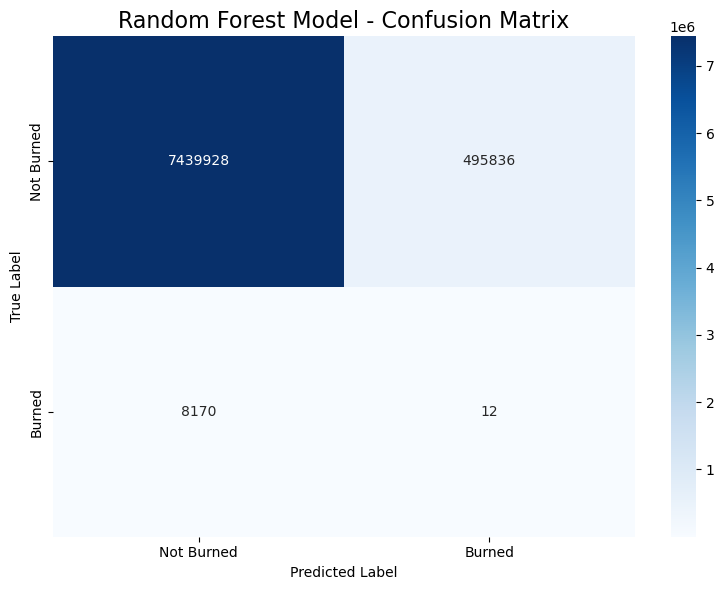

Complete Metric:
{'Accuracy': 0.9365547046769955, 'Balanced Accuracy': 0.46949272066885794, 'Recall (Sensitivity)': 0.0014666340747983377, 'Precision': 2.4200964811797165e-05, 'F1-Score': 4.761621332063568e-05, 'ROC-AUC': 0.37173349274382167, 'Matthews Correlation Coefficient (MCC)': -0.008090225178810723, 'True Positives (TP)': 12, 'False Positives (FP)': 495836, 'True Negatives (TN)': 7439928, 'False Negatives (FN)': 8170, 'Support (Total Positive)': 8182, 'Support (Total Negative)': 7935764}


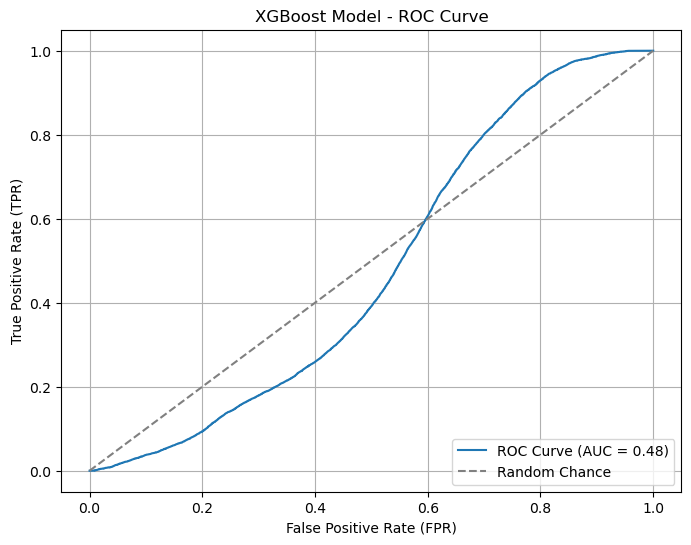

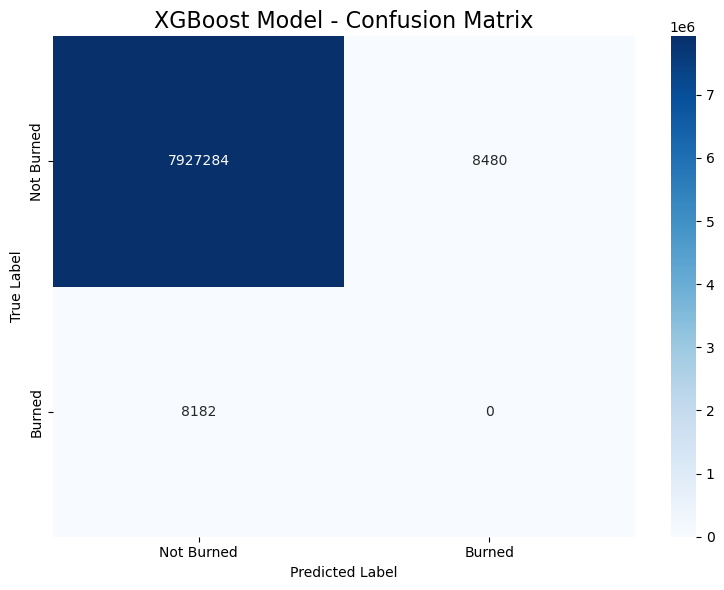

Complete Metric:
{'Accuracy': 0.9979025537182654, 'Balanced Accuracy': 0.49946570991778483, 'Recall (Sensitivity)': 0.0, 'Precision': 0.0, 'F1-Score': 0.0, 'ROC-AUC': 0.4791259761045128, 'Matthews Correlation Coefficient (MCC)': -0.0010496561970077256, 'True Positives (TP)': 0, 'False Positives (FP)': 8480, 'True Negatives (TN)': 7927284, 'False Negatives (FN)': 8182, 'Support (Total Positive)': 8182, 'Support (Total Negative)': 7935764}


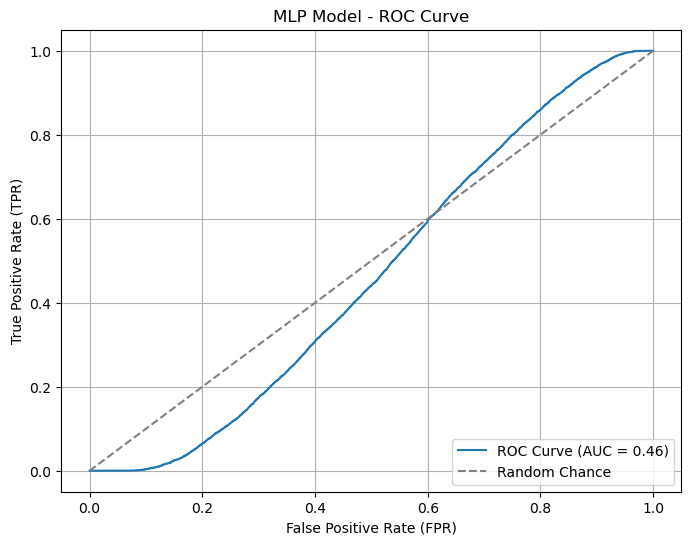

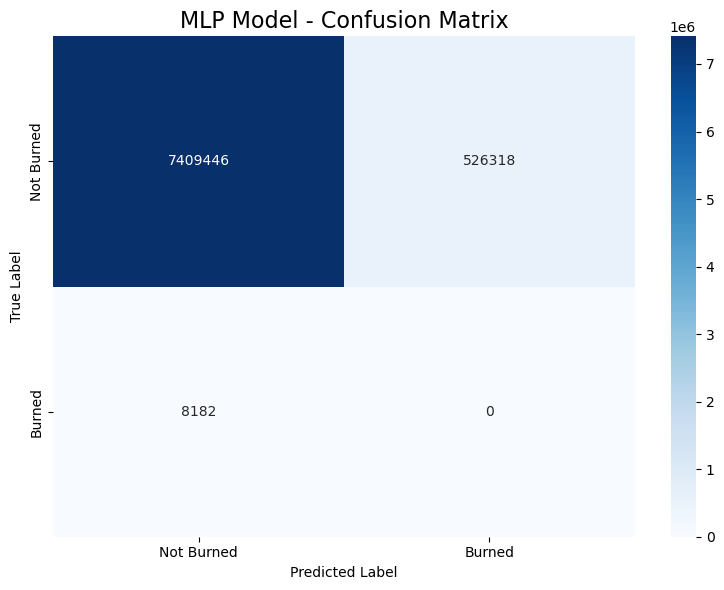

Complete Metric:
{'Accuracy': 0.9327160582410807, 'Balanced Accuracy': 0.46683885760715665, 'Recall (Sensitivity)': 0.0, 'Precision': 0.0, 'F1-Score': 0.0, 'ROC-AUC': 0.4639651976494911, 'Matthews Correlation Coefficient (MCC)': -0.008553167015855057, 'True Positives (TP)': 0, 'False Positives (FP)': 526318, 'True Negatives (TN)': 7409446, 'False Negatives (FN)': 8182, 'Support (Total Positive)': 8182, 'Support (Total Negative)': 7935764}


In [19]:
# Example usage with your dataframe and models
true_label_column = 'Burned'

# Metrics and plots for Random Forest
rf_metrics_20230511 = calculate_metrics_with_plots(
    df_original_20230511, 'RF_Prob', true_label_column, plot_title="Random Forest Model"
)

# Metrics and plots for XGBoost
xgb_metrics_20230511 = calculate_metrics_with_plots(
    df_original_20230511, 'XGB_Prob', true_label_column, plot_title="XGBoost Model"
)

# Metrics and plots for MLP
mlp_metrics_20230511 = calculate_metrics_with_plots(
    df_original_20230511, 'MLP_Prob', true_label_column, plot_title="MLP Model"
)

In [20]:
# Save variables to pickle files
with open('rf_metrics_20230511.pkl', 'wb') as f:
    pickle.dump(rf_metrics_20230511, f)

with open('xgb_metrics_20230511.pkl', 'wb') as f:
    pickle.dump(xgb_metrics_20230511, f)

with open('mlp_metrics_20230511.pkl', 'wb') as f:
    pickle.dump(mlp_metrics_20230511, f)

In [23]:
# Replace commas with dots in the 'POINT_X' column and convert to float
df_original_20230511['POINT_X'] = df_original_20230511['POINT_X'].str.replace(',', '.').astype(float)
df_original_20230511['POINT_Y'] = df_original_20230511['POINT_Y'].str.replace(',', '.').astype(float)
df_original_20230511['POINT_Z'] = df_original_20230511['POINT_Z'].str.replace(',', '.').astype(float)

In [24]:
df_original_20230511_results = df_original_20230511[['point_ID', 'POINT_X', 'POINT_Y', 'POINT_Z', 'RF_Prob', 'XGB_Prob', 'MLP_Prob', 'Burned']]

In [24]:
# Set Pandas display option to avoid scientific notation
pd.set_option('display.float_format', '{:.6f}'.format)

# Now run your describe function again
df_original_20230511_results.describe(include='all').T

count           mean            std            min  \
point_ID 7943946.000000 3978092.274239 2294149.794018       8.000000   
POINT_X  7943946.000000   44962.995130   11452.657205   22842.053501   
POINT_Y  7943946.000000 -242310.321630   29340.880860 -300847.488116   
POINT_Z  7943946.000000       0.000000       0.000000       0.000000   
RF_Prob  7943946.000000       0.249629       0.098134       0.014762   
XGB_Prob 7943946.000000       0.310695       0.040079       0.236296   
MLP_Prob 7943946.000000       0.227870       0.096881       0.000000   
Burned   7943946.000000       0.001030       0.032077       0.000000   

                    25%            50%            75%            max  
point_ID 1992546.250000 3978715.500000 5964701.750000 7960607.000000  
POINT_X    36151.280882   44638.064616   53446.323449   77165.878219  
POINT_Y  -267460.334424 -245273.244838 -215591.741633 -191745.950747  
POINT_Z        0.000000       0.000000       0.000000       0.000000  
RF_Prob        0.184930       0.249174       0.326299       0.453133  
XGB_Prob       0.280139       0.311199       0.342181       0.430063  
MLP_Prob       0.165627       0.210590       0.270563       0.933153  
Burned         0.000000       0.000000       0.000000       1.000000

In [26]:
# Group by 'COS18n1_L' and calculate the percentages using agg
result = df_original_20230511.groupby('COS18n1_L').agg(
    Burned_Percentage=('Burned', lambda x: (x.sum() / len(x)) * 100),  # Percentage of records actually burned
    RF_Prob=('RF_Prob', calculate_percentage),
    XGB_Prob=('XGB_Prob', calculate_percentage),
    MLP_Prob=('MLP_Prob', calculate_percentage),
    Total_Count=('point_ID', 'size'),
)

# Calculate Dataset percentage
total_records = len(df_original_20230511)
result['Dataset_Percentage'] = (result['Total_Count'] / total_records) * 100

result

Burned_Percentage    RF_Prob  \
COS18n1_L                                                                  
Agricultura                                          0.007631   1.241938   
Espaços descobertos ou com pouca vegetação           0.000000   0.000000   
Florestas                                            0.169656  11.373704   
Massas de água superficiais                          0.000000   1.537221   
Matos                                                0.188045  10.794863   
Pastagens                                            0.012977   0.123672   
Superfícies agroflorestais (SAF)                     0.059857   1.325296   
Territórios artificializados                         0.000000   0.131452   
Zonas húmidas                                        0.000000   0.000000   

                                            XGB_Prob   MLP_Prob  Total_Count  \
COS18n1_L                                                                      
Agricultura                                 0.001680   0.678865      1428413   
Espaços descobertos ou com pouca vegetação  0.000000   0.020856        47948   
Florestas                                   0.300516  10.529333      2508022   
Massas de água superficiais                 0.003951   1.372930       303730   
Matos                                       0.053164  13.771591      1572498   
Pastagens                                   0.000000   0.124655       508604   
Superfícies agroflorestais (SAF)            0.005346   1.248950      1328156   
Territórios artificializados                0.000000   0.201044       155190   
Zonas húmidas                               0.000000  15.616348        91385   

                                            Dataset_Percentage  
COS18n1_L                                                       
Agricultura                                          17.981152  
Espaços descobertos ou com pouca vegetação            0.603579  
Florestas                                            31.571489  
Massas de água superficiais                           3.823415  
Matos                                                19.794923  
Pastagens                                             6.402410  
Superfícies agroflorestais (SAF)                     16.719097  
Territórios artificializados                          1.953563  
Zonas húmidas                                         1.150373

In [26]:
df_original_20230511_results.to_csv('df_original_20230511_results_V2.csv')

## 2.2: 2023 07 23 - Subset 2

In [11]:
file_path_20230723 = path+'TestData_20230723_V2.csv'

# Read the CSV file into a DataFrame
df_original_20230723 = pd.read_csv(file_path_20230723, sep=';')

In [12]:
# Define the columns to check
bands_columns = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B11', 'B12']
# Filter out rows where all specified bands are zero
df_original_20230723 = df_original_20230723[~(df_original_20230723[bands_columns].sum(axis=1) == 0)]

In [13]:
id_counts = df_original_20230723.groupby('point_ID').size().reset_index(name='count')
id_counts_more_than_one = id_counts[id_counts['count'] > 1]
id_counts_more_than_one.count()
duplicates = df_original_20230723[df_original_20230723['point_ID'].isin(id_counts_more_than_one['point_ID'])]
duplicates_sorted = duplicates.sort_values(by='point_ID')
indices_to_drop = duplicates_sorted.iloc[1::2].index
df_original_20230723 = df_original_20230723.drop(indices_to_drop)

# Display the DataFrame
df_original_20230723.sort_values(by='point_ID')

Burned   B02   B03   B04   B05   B06   B07   B08   B11   B12  \
5872183        0  1567  1507  1407  1414  1375  1361  1356  1337  1288   
5872184        0  1506  1485  1420  1412  1384  1374  1381  1348  1310   
5872185        0  1530  1512  1397  1410  1382  1394  1388  1343  1298   
5872560        0  1502  1501  1410  1406  1395  1391  1354  1335  1292   
5872561        0  1514  1486  1387  1383  1351  1355  1339  1328  1274   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
24449587       0  1304  1487  1811  1928  1988  2015  2079  2522  2310   
24449588       0  1378  1581  1937  2045  2104  2140  2197  2695  2467   
24449589       0  1397  1604  1918  2027  2085  2113  2194  2760  2505   
24449590       0  1390  1583  1898  2032  2074  2120  2166  2782  2524   
24449591       0  1397  1616  1989  2172  2182  2261  2284  2958  2645   

            Elevation      Slope       Aspect  point_ID  \
5872183           NaN        NaN          NaN         1   
5872184           NaN        NaN          NaN         2   
5872185           NaN        NaN          NaN         3   
5872560           NaN        NaN          NaN         4   
5872561           NaN        NaN          NaN         5   
...               ...        ...          ...       ...   
24449587  195,2555695  2,4598536  178,9616089  24480279   
24449588  195,0720673  2,8174024  145,0923157  24480280   
24449589  194,2091522  2,5088491  133,0476532  24480281   
24449590  194,1644592  0,8858909  167,7752838  24480282   
24449591  194,1644592  0,8858909  167,7752838  24480283   

                        POINT_X                  POINT_Y            POINT_Z  \
5872183   14336,670979054251802  -298929,298560334427748  0,000000000000000   
5872184   14356,676140243731425  -298929,480633034778293  0,000000000000000   
5872185   14376,681300674137674  -298929,662705730530433  0,000000000000000   
5872560   14296,842727491864935  -298908,929251822875813  0,000000000000000   
5872561   14316,847890194705542  -298909,111325296107680  0,000000000000000   
...                         ...                      ...                ...   
24449587  33529,497600165486801  -191691,043407759221736  0,000000000000000   
24449588  33549,502048283815384  -191691,229534863086883  0,000000000000000   
24449589  33569,506495652225567  -191691,415661963983439  0,000000000000000   
24449590  33589,510942271699605  -191691,601789061125601  0,000000000000000   
24449591  33609,515388135405374  -191691,787916153232800  0,000000000000000   

          COS18n1_C                    COS18n1_L  
5872183           9  Massas de água superficiais  
5872184           9  Massas de água superficiais  
5872185           9  Massas de água superficiais  
5872560           9  Massas de água superficiais  
5872561           9  Massas de água superficiais  
...             ...                          ...  
24449587          2                  Agricultura  
24449588          2                  Agricultura  
24449589          2                  Agricultura  
24449590          2                  Agricultura  
24449591          2                  Agricultura  

[24027162 rows x 19 columns]

In [14]:
# Count the number of 0s and 1s in the 'Burned' column
count_0 = (df_original_20230723['Burned'] == 0).sum()
count_1 = (df_original_20230723['Burned'] == 1).sum()

# Calculate the ratio of count_1 to count_0 as a percentage
ratio = (count_1 / count_0) * 100

# Print the counts and the ratio
print(f"Number of 0s: {count_0}")
print(f"Number of 1s: {count_1}")
print(f"Ratio of 1s to 0s: {ratio:.6f}%")

Number of 0s: 24023107
Number of 1s: 4055
Ratio of 1s to 0s: 0.016880%


In [15]:
df_original_20230723.describe(include='all').T

count    unique                      top      freq  \
Burned     24027162.0       NaN                      NaN       NaN   
B02        24027162.0       NaN                      NaN       NaN   
B03        24027162.0       NaN                      NaN       NaN   
B04        24027162.0       NaN                      NaN       NaN   
B05        24027162.0       NaN                      NaN       NaN   
B06        24027162.0       NaN                      NaN       NaN   
B07        24027162.0       NaN                      NaN       NaN   
B08        24027162.0       NaN                      NaN       NaN   
B11        24027162.0       NaN                      NaN       NaN   
B12        24027162.0       NaN                      NaN       NaN   
Elevation    23282193  11028249              123,8052902     39370   
Slope        23256513  12460560                0,0000000    120637   
Aspect       23252891  11093208               -1,0000000    120316   
point_ID   24027162.0       NaN                      NaN       NaN   
POINT_X      24027162  24027162   -73085,682897671838873         1   
POINT_Y      24027162  24027162  -297313,214448316197377         1   
POINT_Z      24027162         1        0,000000000000000  24027162   
COS18n1_C  24027162.0       NaN                      NaN       NaN   
COS18n1_L    24027162         9                Florestas   8459484   

                      mean             std     min         25%         50%  \
Burned            0.000169         0.01299     0.0         0.0         0.0   
B02            1668.512634      314.025885  1062.0      1443.0      1618.0   
B03            1958.244455      400.135242  1104.0      1658.0      1892.0   
B04            2248.977649      587.560384  1042.0      1782.0      2193.0   
B05            2580.053848      576.735847   799.0      2158.0      2520.0   
B06            2990.091474      549.072695   683.0      2682.0      2962.0   
B07            3188.692738       590.98125   706.0      2870.0      3169.0   
B08            3425.106691      626.867895   744.0      3103.0      3423.0   
B11            4174.483877     1044.022088   954.0      3444.0      4168.0   
B12            3303.405763      916.641066   976.0      2605.0      3279.0   
Elevation              NaN             NaN     NaN         NaN         NaN   
Slope                  NaN             NaN     NaN         NaN         NaN   
Aspect                 NaN             NaN     NaN         NaN         NaN   
point_ID   12093279.826767  6998747.355024     1.0  6027067.25  12077713.5   
POINT_X                NaN             NaN     NaN         NaN         NaN   
POINT_Y                NaN             NaN     NaN         NaN         NaN   
POINT_Z                NaN             NaN     NaN         NaN         NaN   
COS18n1_C         4.188788        1.833574     1.0         2.0         5.0   
COS18n1_L              NaN             NaN     NaN         NaN         NaN   

                   75%         max  
Burned             0.0         1.0  
B02             1832.0     19025.0  
B03             2180.0     18007.0  
B04             2628.0     17363.0  
B05             2927.0     17051.0  
B06             3281.0     16970.0  
B07             3503.0     16801.0  
B08             3767.0     16641.0  
B11             4979.0     16149.0  
B12             4011.0     16090.0  
Elevation          NaN         NaN  
Slope              NaN         NaN  
Aspect             NaN         NaN  
point_ID   18155443.75  24480283.0  
POINT_X            NaN         NaN  
POINT_Y            NaN         NaN  
POINT_Z            NaN         NaN  
COS18n1_C          5.0         9.0  
COS18n1_L          NaN         NaN

In [15]:
# Prepare the data - Subset 2
RF_df_20230732_subset_2_with_outliers_NESW = process_wildfire_data(df_original_20230723, has_outliers=True, aspect_info='NESW', subset='subset_2')
# XGB_df_20230732_subset_2_no_outliers_no_Aspect = process_wildfire_data(df_original_20230723, has_outliers=False, aspect_info='none', subset='subset_2')
# MLP_df_20230732_subset_2_with_outliers_no_Aspect = process_wildfire_data(df_original_20230723, has_outliers=True, aspect_info='none', subset='subset_2')

In [16]:
RF_df_20230732_subset_2_with_outliers_NESW = RF_df_20230732_subset_2_with_outliers_NESW.drop(columns=['point_ID', 'POINT_X', 'POINT_Y', 'POINT_Z', 'Burned'])
# XGB_df_20230732_subset_2_no_outliers_no_Aspect = XGB_df_20230732_subset_2_no_outliers_no_Aspect.drop(columns=['point_ID', 'POINT_X', 'POINT_Y', 'POINT_Z', 'Burned'])
# MLP_df_20230732_subset_2_with_outliers_no_Aspect = MLP_df_20230732_subset_2_with_outliers_no_Aspect.drop(columns=['point_ID', 'POINT_X', 'POINT_Y', 'POINT_Z', 'Burned'])

In [18]:
# For Random Forest: rf_model_2_df_subset_2_NESW_final
df_original_20230723['RF_Prob'] = rf_model_2_df_subset_2_NESW_final.predict_proba(RF_df_20230732_subset_2_with_outliers_NESW)[:, 1]

# For XGBoost: xgb_model_2_df_subset_2_no_outliers_NESW_final
df_original_20230723['XGB_Prob'] = xgb_model_2_df_subset_2_no_outliers_no_Aspect_final.predict_proba(XGB_df_20230732_subset_2_no_outliers_no_Aspect)[:, 1]

# For MLP: mlp_model_2_df_subset_2_no_Aspect_final
MLP_df_20230732_subset_2_with_outliers_no_Aspect_scaled = scaler_mlp_model_2_final.transform(MLP_df_20230732_subset_2_with_outliers_no_Aspect)
df_original_20230723['MLP_Prob'] = mlp_model_2_df_subset_2_no_Aspect_final.predict_proba(MLP_df_20230732_subset_2_with_outliers_no_Aspect_scaled)[:, 1]

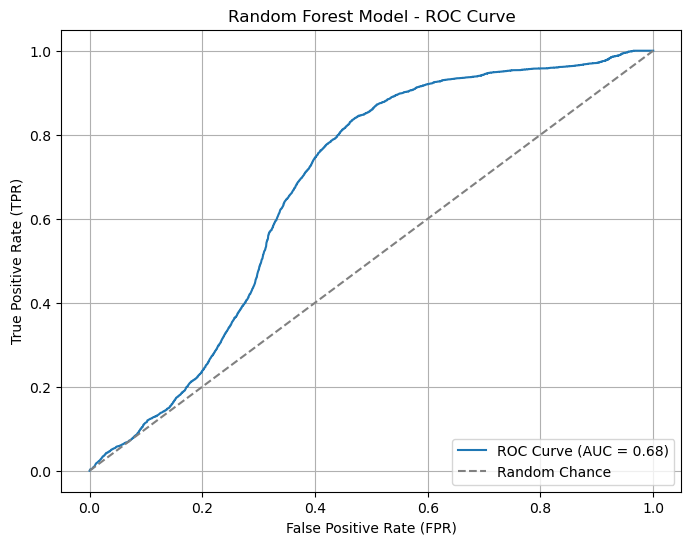

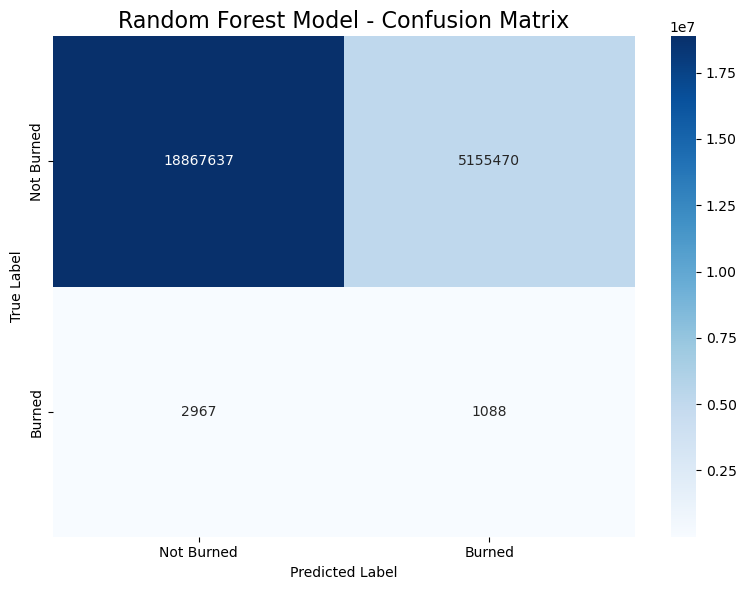

Complete Metric:
{'Accuracy': 0.7853081025549334, 'Balanced Accuracy': 0.5268530485233714, 'Recall': 0.26831072749691737, 'Precision': 0.00021099345726354672, 'F1-Score': 0.00042165533435659677, 'ROC-AUC': 0.6752254179994844, 'Matthews Correlation Coefficient (MCC)': 0.001699263603533722, 'True Positives (TP)': 1088, 'False Positives (FP)': 5155470, 'True Negatives (TN)': 18867637, 'False Negatives (FN)': 2967, 'Support (Total Positive)': 4055, 'Support (Total Negative)': 24023107}


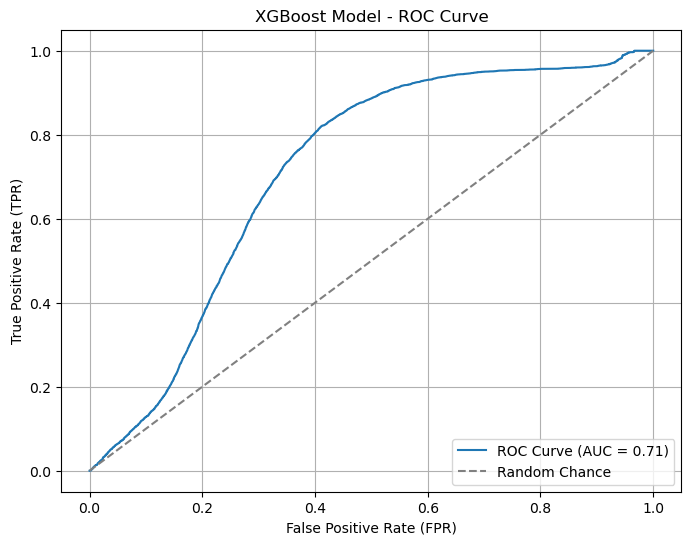

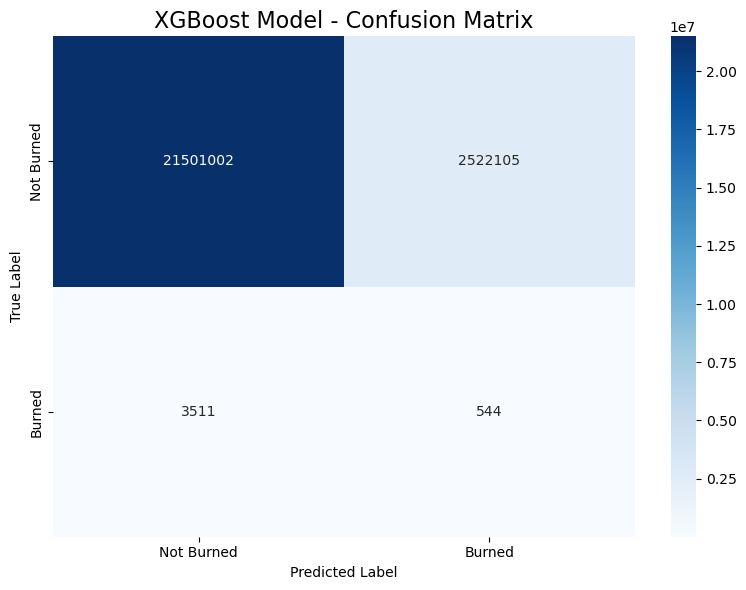

Complete Metric:
{'Accuracy': 0.8948849639420585, 'Balanced Accuracy': 0.5145843678328774, 'Recall': 0.13415536374845868, 'Precision': 0.00021564633050416448, 'F1-Score': 0.0004306004977235165, 'ROC-AUC': 0.7129528752007416, 'Matthews Correlation Coefficient (MCC)': 0.001236045342228366, 'True Positives (TP)': 544, 'False Positives (FP)': 2522105, 'True Negatives (TN)': 21501002, 'False Negatives (FN)': 3511, 'Support (Total Positive)': 4055, 'Support (Total Negative)': 24023107}


C:\Users\Afonso Lavado\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


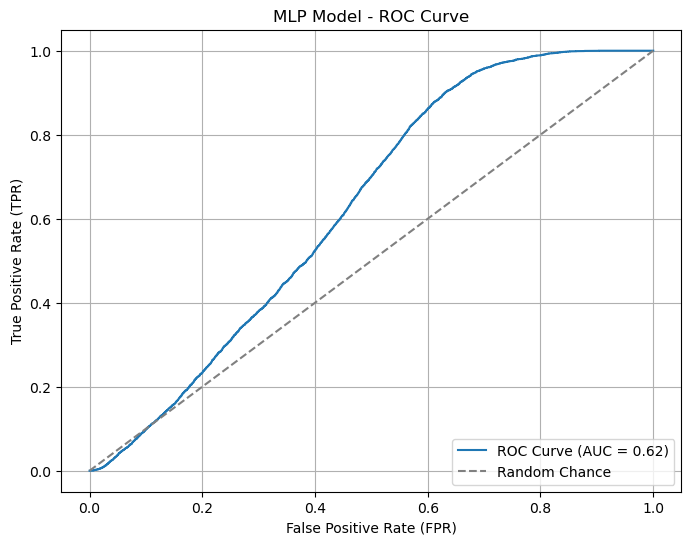

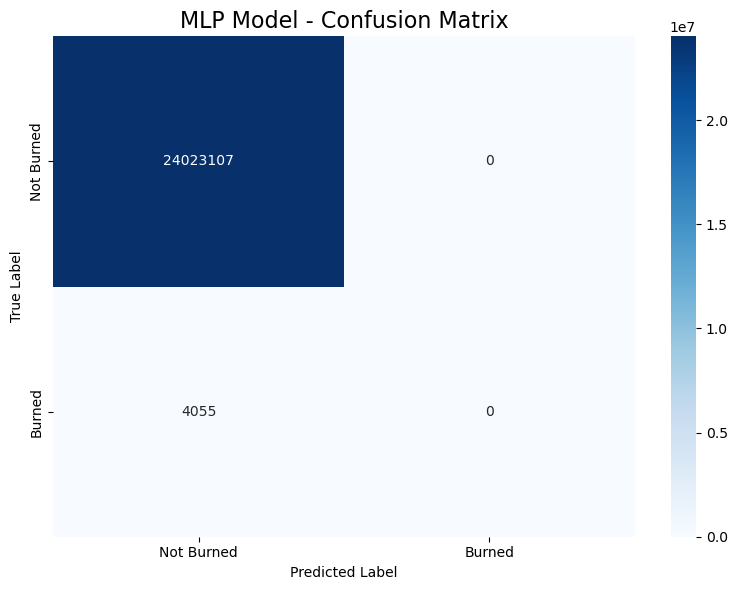

Complete Metric:
{'Accuracy': 0.9998312326690935, 'Balanced Accuracy': 0.5, 'Recall': 0.0, 'Precision': 0.0, 'F1-Score': 0.0, 'ROC-AUC': 0.6247053110039597, 'Matthews Correlation Coefficient (MCC)': 0.0, 'True Positives (TP)': 0, 'False Positives (FP)': 0, 'True Negatives (TN)': 24023107, 'False Negatives (FN)': 4055, 'Support (Total Positive)': 4055, 'Support (Total Negative)': 24023107}


In [18]:
# Example usage with your dataframe and models
true_label_column = 'Burned'

# Metrics and plots for Random Forest
rf_metrics_20230723 = calculate_metrics_with_plots(
    df_original_20230723, 'RF_Prob', true_label_column, plot_title="Random Forest Model"
)

# Metrics and plots for XGBoost
xgb_metrics_20230723 = calculate_metrics_with_plots(
    df_original_20230723, 'XGB_Prob', true_label_column, plot_title="XGBoost Model"
)

# Metrics and plots for MLP
mlp_metrics_20230723 = calculate_metrics_with_plots(
    df_original_20230723, 'MLP_Prob', true_label_column, plot_title="MLP Model"
)

In [19]:
# Save variables to pickle files
with open('rf_metrics_20230723.pkl', 'wb') as f:
    pickle.dump(rf_metrics_20230723, f)

with open('xgb_metrics_20230723.pkl', 'wb') as f:
    pickle.dump(xgb_metrics_20230723, f)

with open('mlp_metrics_20230723.pkl', 'wb') as f:
    pickle.dump(mlp_metrics_20230723, f)

In [17]:
RF_df_20230732_subset_2_with_outliers_NESW['RF_Prob'] = rf_model_2_df_subset_2_NESW_final.predict_proba(RF_df_20230732_subset_2_with_outliers_NESW)[:, 1]

In [18]:
target_variable = 'RF_Prob'

features = RF_df_20230732_subset_2_with_outliers_NESW.drop(target_variable, axis=1)  # Exclude the target variable
target = RF_df_20230732_subset_2_with_outliers_NESW[target_variable]

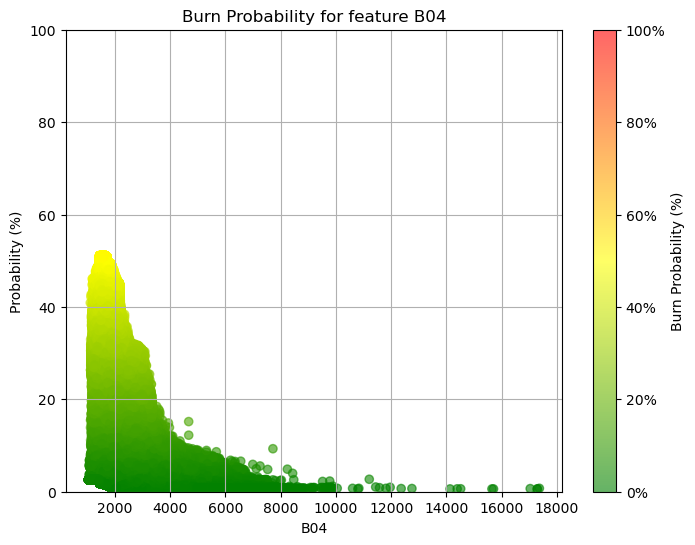

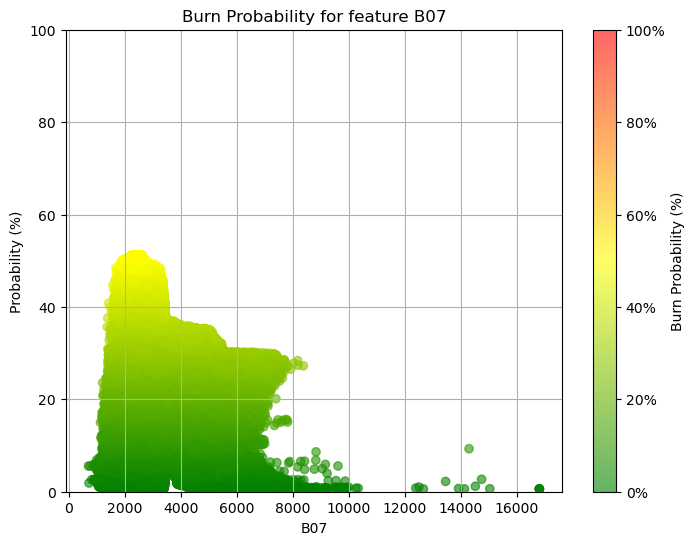

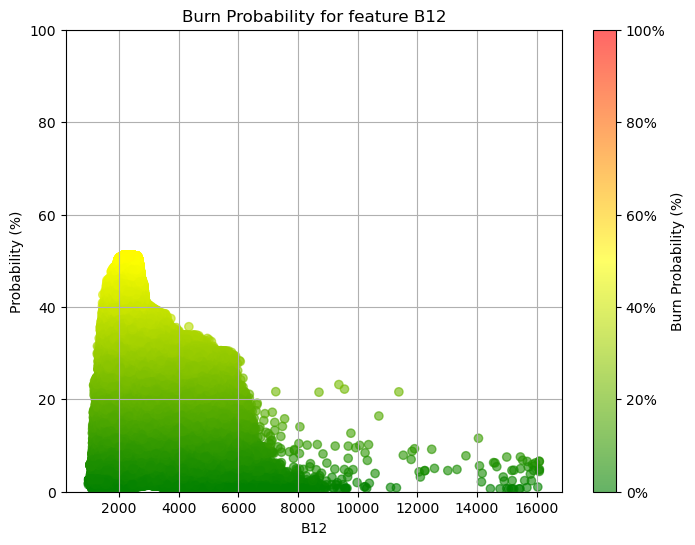

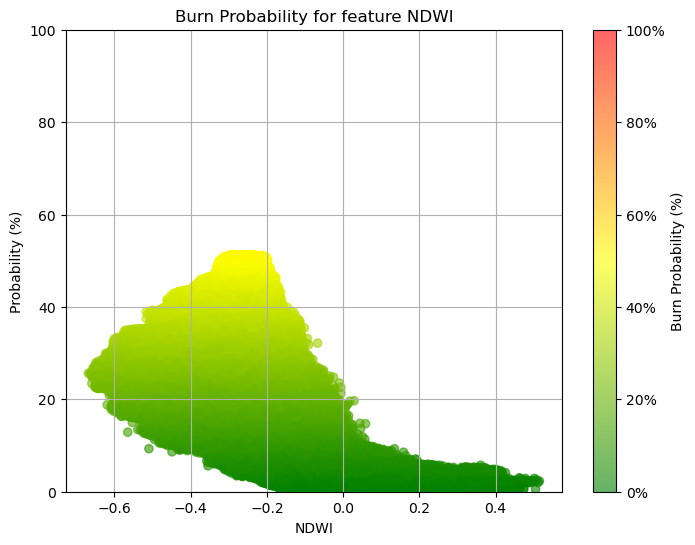

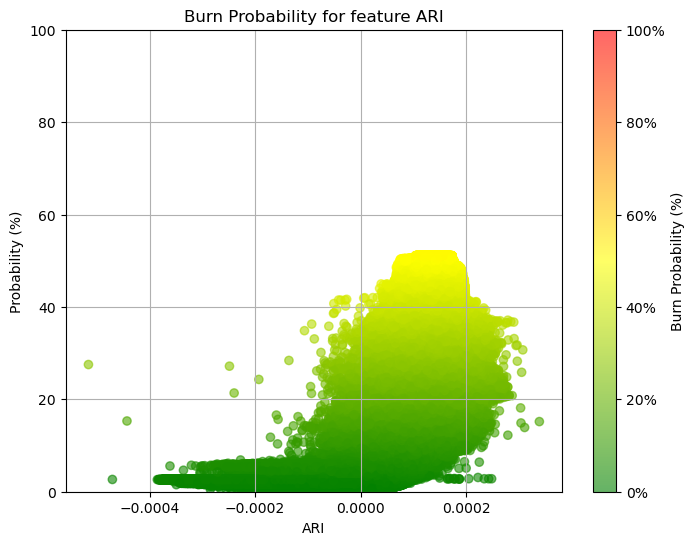

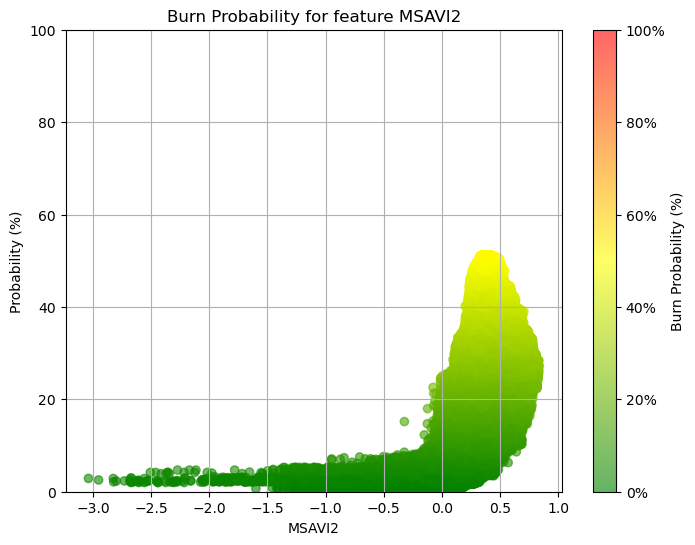

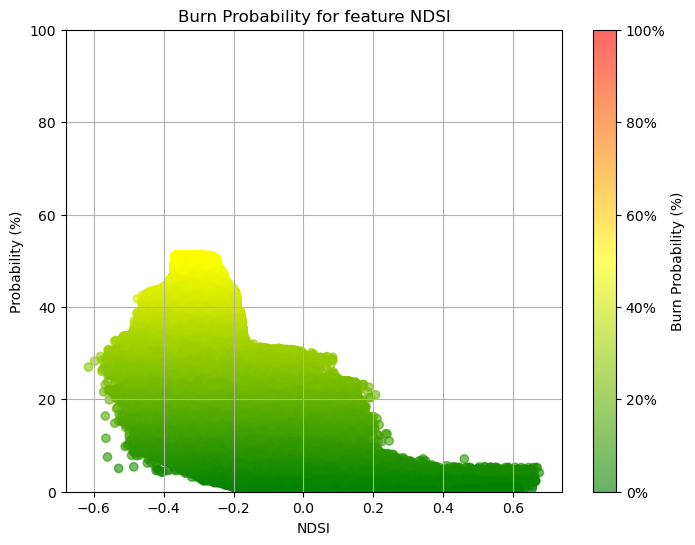

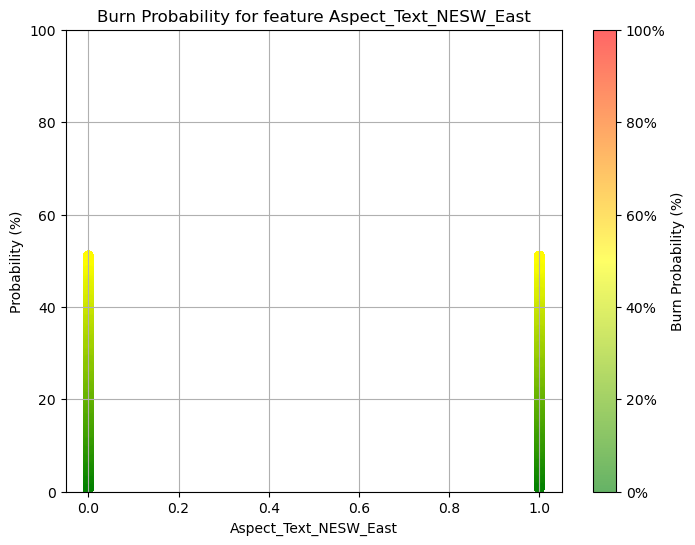

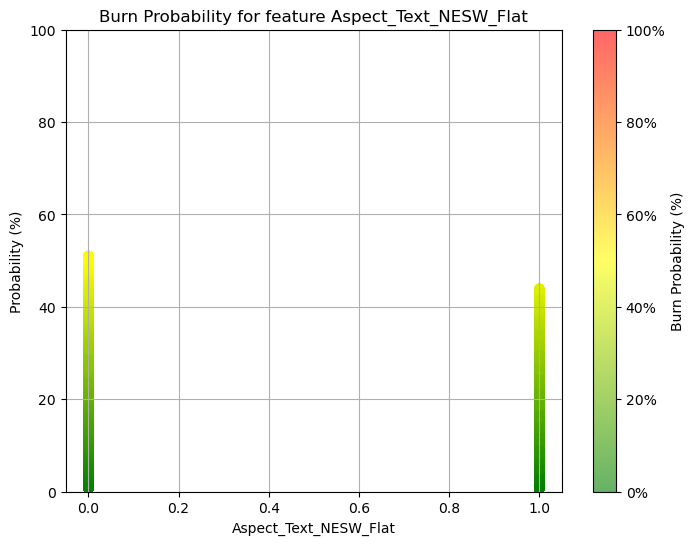

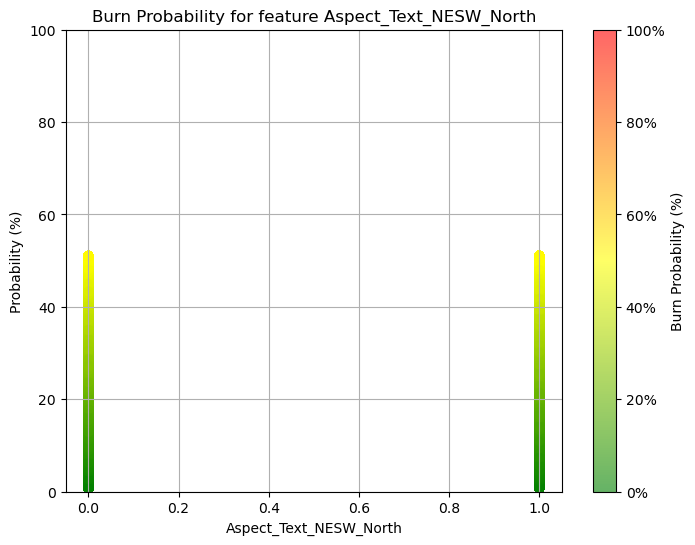

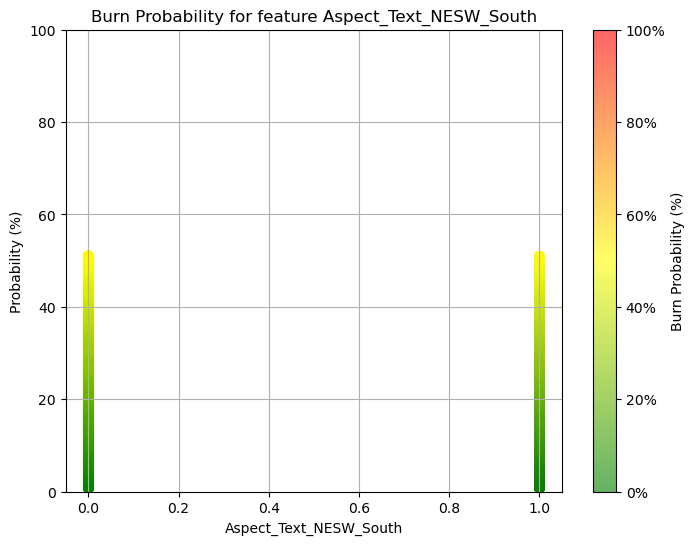

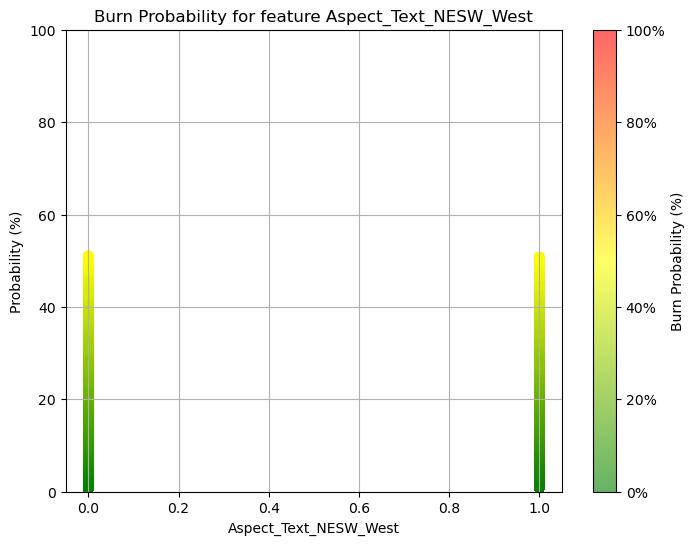

In [22]:
# Define a green-yellow-red colormap
cmap = mcolors.LinearSegmentedColormap.from_list('GreenYellowRed', ['green', 'yellow', 'red'])

# Set fixed range for target values (0 to 100%)
vmin, vmax = 0, 100

# Create a scatter plot for each feature
for feature in features:
    plt.figure(figsize=(8, 6))

    # Scale target to 0-100 for consistent plotting
    target_scaled = target * 100

    # Scatter plot colored by the target variable
    scatter = plt.scatter(features[feature], target_scaled, c=target_scaled, cmap=cmap, alpha=0.6, vmin=vmin, vmax=vmax)

    # Add labels and title
    plt.xlabel(feature)
    plt.ylabel("Probability (%)")
    plt.title(f'Burn Probability for feature {feature}')

    # Add colorbar legend with fixed scale and consistent colormap
    cbar = plt.colorbar(scatter)  # Ensure the colorbar uses the same scatter object
    cbar.set_label('Burn Probability (%)')
    cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))
    cbar.set_ticks(np.linspace(vmin, vmax, 6))  # Ensure ticks span 0% to 100%

    # Set consistent y-axis limits (0 to 100%)
    plt.ylim(vmin, vmax)

    # Add grid
    plt.grid(True)

    # Show plot
    plt.show()

In [19]:
# Replace commas with dots in the 'POINT_{X, Y, Z}' columns and convert to float
df_original_20230723['POINT_X'] = df_original_20230723['POINT_X'].str.replace(',', '.').astype(float)
df_original_20230723['POINT_Y'] = df_original_20230723['POINT_Y'].str.replace(',', '.').astype(float)
df_original_20230723['POINT_Z'] = df_original_20230723['POINT_Z'].str.replace(',', '.').astype(float)

In [20]:
df_original_20230723_results = df_original_20230723[['point_ID', 'POINT_X', 'POINT_Y', 'POINT_Z', 'RF_Prob', 'XGB_Prob', 'MLP_Prob', 'Burned']]

In [22]:
# Set Pandas display option to avoid scientific notation
pd.set_option('display.float_format', '{:.6f}'.format)

# Now run your describe function again
df_original_20230723_results.describe(include='all').T

count            mean            std            min  \
point_ID 24027162.000000 12093279.826767 6998747.355024       1.000000   
POINT_X  24027162.000000   -14369.476514   28539.141562  -77071.323672   
POINT_Y  24027162.000000  -242311.689883   29328.234549 -301405.439807   
POINT_Z  24027162.000000        0.000000       0.000000       0.000000   
RF_Prob  24027162.000000        0.294017       0.117746       0.005234   
XGB_Prob 24027162.000000        0.320299       0.065323       0.210153   
MLP_Prob 24027162.000000        0.288023       0.033726       0.132891   
Burned   24027162.000000        0.000169       0.012990       0.000000   

                    25%             50%             75%             max  
point_ID 6027067.250000 12077713.500000 18155443.750000 24480283.000000  
POINT_X   -38743.989994   -13580.030220    10759.139899    33609.515388  
POINT_Y  -267683.108609  -242729.736666  -216910.926446  -190772.794809  
POINT_Z        0.000000        0.000000        0.000000        0.000000  
RF_Prob        0.212635        0.297123        0.376847        0.510724  
XGB_Prob       0.275303        0.314145        0.363704        0.521340  
MLP_Prob       0.261767        0.287793        0.315203        0.371020  
Burned         0.000000        0.000000        0.000000        1.000000

In [21]:
# Group by 'COS18n1_L' and calculate the percentages using agg
result = df_original_20230723.groupby('COS18n1_L').agg(
    Burned_Percentage=('Burned', lambda x: (x.sum() / len(x)) * 100),  # Percentage of records actually burned
    RF_Prob=('RF_Prob', calculate_percentage),
    XGB_Prob=('XGB_Prob', calculate_percentage),
    MLP_Prob=('MLP_Prob', calculate_percentage),
    Total_Count=('point_ID', 'size'),
)

# Calculate Dataset percentage
total_records = len(df_original_20230723)
result['Dataset_Percentage'] = (result['Total_Count'] / total_records) * 100

result

Burned_Percentage    RF_Prob  \
COS18n1_L                                                                  
Agricultura                                          0.000138   1.853709   
Espaços descobertos ou com pouca vegetação           0.000000   1.632771   
Florestas                                            0.020096  40.410491   
Massas de água superficiais                          0.000000   2.792793   
Matos                                                0.037189  45.395772   
Pastagens                                            0.036638   2.504194   
Superfícies agroflorestais (SAF)                     0.002726   3.050942   
Territórios artificializados                         0.032413   1.497045   
Zonas húmidas                                        0.000000   5.135853   

                                             XGB_Prob  MLP_Prob  Total_Count  \
COS18n1_L                                                                      
Agricultura                                  2.388982       0.0      5788449   
Espaços descobertos ou com pouca vegetação   0.641761       0.0        79313   
Florestas                                   16.428165       0.0      8459484   
Massas de água superficiais                  1.141825       0.0       994023   
Matos                                       25.917069       0.0      3205239   
Pastagens                                    3.829870       0.0      2311802   
Superfícies agroflorestais (SAF)             2.559954       0.0      2273986   
Territórios artificializados                 0.513069       0.0       758962   
Zonas húmidas                                0.908893       0.0       155904   

                                            Dataset_Percentage  
COS18n1_L                                                       
Agricultura                                          24.091272  
Espaços descobertos ou com pouca vegetação            0.330097  
Florestas                                            35.208003  
Massas de água superficiais                           4.137080  
Matos                                                13.340065  
Pastagens                                             9.621619  
Superfícies agroflorestais (SAF)                      9.464231  
Territórios artificializados                          3.158767  
Zonas húmidas                                         0.648866

In [24]:
df_original_20230723_results.to_csv('df_20230723_results_V2.csv')

## 2.3: 2023 08 02 - Subset 2

In [11]:
file_path_20230802 = path+'TestData_20230802_V2.csv'

# Read the CSV file into a DataFrame
df_original_20230802 = pd.read_csv(file_path_20230802, sep=';')

In [12]:
# Define the columns to check
bands_columns = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B11', 'B12']
# Filter out rows where all specified bands are zero
df_original_20230802 = df_original_20230802[~(df_original_20230802[bands_columns].sum(axis=1) == 0)]

In [13]:
id_counts = df_original_20230802.groupby('point_ID').size().reset_index(name='count')
id_counts_more_than_one = id_counts[id_counts['count'] > 1]
id_counts_more_than_one.count()
duplicates = df_original_20230802[df_original_20230802['point_ID'].isin(id_counts_more_than_one['point_ID'])]
duplicates_sorted = duplicates.sort_values(by='point_ID')
indices_to_drop = duplicates_sorted.iloc[1::2].index
df_original_20230802 = df_original_20230802.drop(indices_to_drop)

# Display the DataFrame
df_original_20230802.sort_values(by='point_ID')

Burned   B02   B03   B04   B05   B06   B07   B08   B11   B12  \
5872183        0  1547  1562  1492  1507  1470  1463  1454  1442  1393   
5872184        0  1572  1557  1495  1530  1480  1457  1468  1449  1388   
5872185        0  1628  1616  1509  1538  1507  1477  1442  1457  1386   
5872560        0  1552  1538  1447  1475  1447  1440  1417  1409  1374   
5872561        0  1560  1570  1482  1485  1452  1450  1441  1425  1382   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
24449587       0  1280  1467  1778  1902  1941  1984  2014  2492  2281   
24449588       0  1340  1559  1902  2043  2038  2097  2170  2647  2411   
24449589       0  1372  1581  1906  2021  2054  2109  2150  2723  2483   
24449590       0  1353  1557  1874  1991  2027  2098  2130  2784  2516   
24449591       0  1371  1589  1973  2124  2142  2240  2250  2923  2598   

            Elevation      Slope       Aspect  point_ID  \
5872183           NaN        NaN          NaN         1   
5872184           NaN        NaN          NaN         2   
5872185           NaN        NaN          NaN         3   
5872560           NaN        NaN          NaN         4   
5872561           NaN        NaN          NaN         5   
...               ...        ...          ...       ...   
24449587  195,2555695  2,4598536  178,9616089  24480279   
24449588  195,0720673  2,8174024  145,0923157  24480280   
24449589  194,2091522  2,5088491  133,0476532  24480281   
24449590  194,1644592  0,8858909  167,7752838  24480282   
24449591  194,1644592  0,8858909  167,7752838  24480283   

                        POINT_X                  POINT_Y            POINT_Z  \
5872183   14336,670979054251802  -298929,298560334427748  0,000000000000000   
5872184   14356,676140243731425  -298929,480633034778293  0,000000000000000   
5872185   14376,681300674137674  -298929,662705730530433  0,000000000000000   
5872560   14296,842727491864935  -298908,929251822875813  0,000000000000000   
5872561   14316,847890194705542  -298909,111325296107680  0,000000000000000   
...                         ...                      ...                ...   
24449587  33529,497600165486801  -191691,043407759221736  0,000000000000000   
24449588  33549,502048283815384  -191691,229534863086883  0,000000000000000   
24449589  33569,506495652225567  -191691,415661963983439  0,000000000000000   
24449590  33589,510942271699605  -191691,601789061125601  0,000000000000000   
24449591  33609,515388135405374  -191691,787916153232800  0,000000000000000   

          COS18n1_C                    COS18n1_L  
5872183           9  Massas de água superficiais  
5872184           9  Massas de água superficiais  
5872185           9  Massas de água superficiais  
5872560           9  Massas de água superficiais  
5872561           9  Massas de água superficiais  
...             ...                          ...  
24449587          2                  Agricultura  
24449588          2                  Agricultura  
24449589          2                  Agricultura  
24449590          2                  Agricultura  
24449591          2                  Agricultura  

[24027162 rows x 19 columns]

In [13]:
df_original_20230802.describe(include='all').T

count    unique                      top      freq  \
Burned     24027162.0       NaN                      NaN       NaN   
B02        24027162.0       NaN                      NaN       NaN   
B03        24027162.0       NaN                      NaN       NaN   
B04        24027162.0       NaN                      NaN       NaN   
B05        24027162.0       NaN                      NaN       NaN   
B06        24027162.0       NaN                      NaN       NaN   
B07        24027162.0       NaN                      NaN       NaN   
B08        24027162.0       NaN                      NaN       NaN   
B11        24027162.0       NaN                      NaN       NaN   
B12        24027162.0       NaN                      NaN       NaN   
Elevation    23282193  11028249              123,8052902     39370   
Slope        23256513  12460560                0,0000000    120637   
Aspect       23252891  11093208               -1,0000000    120316   
point_ID   24027162.0       NaN                      NaN       NaN   
POINT_X      24027162  24027162   -73085,682897671838873         1   
POINT_Y      24027162  24027162  -297313,214448316197377         1   
POINT_Z      24027162         1        0,000000000000000  24027162   
COS18n1_C  24027162.0       NaN                      NaN       NaN   
COS18n1_L    24027162         9                Florestas   8459481   

                      mean             std     min         25%         50%  \
Burned            0.007825        0.088111     0.0         0.0         0.0   
B02            1841.117775      745.090284   720.0      1456.0      1671.0   
B03            2121.346415      728.404326   943.0      1681.0      1965.0   
B04            2407.757035      816.305951   972.0      1824.0      2291.0   
B05            2757.466496      815.152338   912.0      2207.0      2632.0   
B06            3133.133563      748.279373   639.0      2715.0      3040.0   
B07            3325.746424      764.040325   676.0      2900.0      3247.0   
B08            3557.685829      781.692331   800.0      3130.0      3498.0   
B11            4277.462546      1110.39604  1027.0      3471.0      4239.0   
B12            3385.672466      976.107868   983.0      2632.0      3339.0   
Elevation              NaN             NaN     NaN         NaN         NaN   
Slope                  NaN             NaN     NaN         NaN         NaN   
Aspect                 NaN             NaN     NaN         NaN         NaN   
point_ID   12093279.826767  6998747.355024     1.0  6027067.25  12077713.5   
POINT_X                NaN             NaN     NaN         NaN         NaN   
POINT_Y                NaN             NaN     NaN         NaN         NaN   
POINT_Z                NaN             NaN     NaN         NaN         NaN   
COS18n1_C         4.188789        1.833575     1.0         2.0         5.0   
COS18n1_L              NaN             NaN     NaN         NaN         NaN   

                   75%         max  
Burned             0.0         1.0  
B02             1945.0     19271.0  
B03             2321.0     18228.0  
B04             2794.0     17477.0  
B05             3118.0     17216.0  
B06             3435.0     17059.0  
B07             3655.0     16936.0  
B08             3917.0     16745.0  
B11             5107.0     16166.0  
B12             4107.0     16103.0  
Elevation          NaN         NaN  
Slope              NaN         NaN  
Aspect             NaN         NaN  
point_ID   18155443.75  24480283.0  
POINT_X            NaN         NaN  
POINT_Y            NaN         NaN  
POINT_Z            NaN         NaN  
COS18n1_C          5.0         9.0  
COS18n1_L          NaN         NaN

In [14]:
# Prepare the data - Subset 2
RF_df_20230802_subset_2_with_outliers_NESW = process_wildfire_data(df_original_20230802, has_outliers=True, aspect_info='NESW', subset='subset_2')
XGB_df_20230802_subset_2_no_outliers_no_Aspect = process_wildfire_data(df_original_20230802, has_outliers=False, aspect_info='none', subset='subset_2')
MLP_df_20230802_subset_2_with_outliers_no_Aspect = process_wildfire_data(df_original_20230802, has_outliers=True, aspect_info='none', subset='subset_2')

In [15]:
RF_df_20230802_subset_2_with_outliers_NESW = RF_df_20230802_subset_2_with_outliers_NESW.drop(columns=['point_ID', 'POINT_X', 'POINT_Y', 'POINT_Z', 'Burned'])
XGB_df_20230802_subset_2_no_outliers_no_Aspect = XGB_df_20230802_subset_2_no_outliers_no_Aspect.drop(columns=['point_ID', 'POINT_X', 'POINT_Y', 'POINT_Z', 'Burned'])
MLP_df_20230802_subset_2_with_outliers_no_Aspect = MLP_df_20230802_subset_2_with_outliers_no_Aspect.drop(columns=['point_ID', 'POINT_X', 'POINT_Y', 'POINT_Z', 'Burned'])

In [16]:
# For Random Forest: rf_model_2_df_subset_2_NESW_final
df_original_20230802['RF_Prob'] = rf_model_2_df_subset_2_NESW_final.predict_proba(RF_df_20230802_subset_2_with_outliers_NESW)[:, 1]

# For XGBoost: xgb_model_2_df_subset_2_no_outliers_NESW_final
df_original_20230802['XGB_Prob'] = xgb_model_2_df_subset_2_no_outliers_no_Aspect_final.predict_proba(XGB_df_20230802_subset_2_no_outliers_no_Aspect)[:, 1]

# For MLP: mlp_model_2_df_subset_2_no_Aspect_final
MLP_df_20230802_subset_2_with_outliers_no_Aspect_scaled = scaler_mlp_model_2_final.transform(MLP_df_20230802_subset_2_with_outliers_no_Aspect)
df_original_20230802['MLP_Prob'] = mlp_model_2_df_subset_2_no_Aspect_final.predict_proba(MLP_df_20230802_subset_2_with_outliers_no_Aspect_scaled)[:, 1]

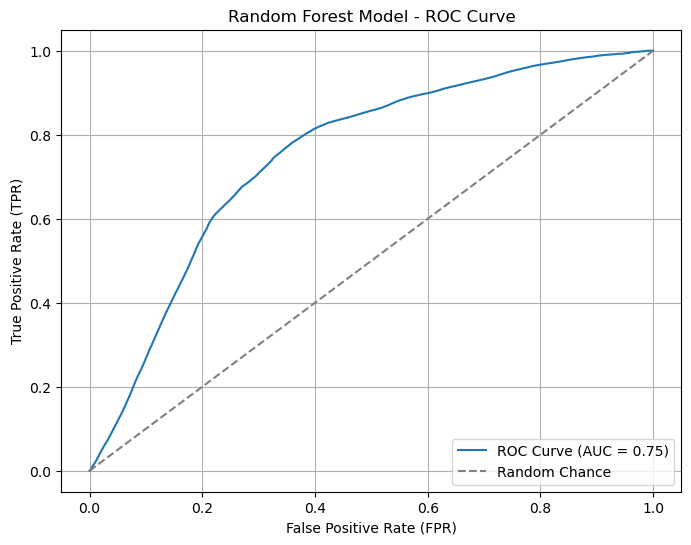

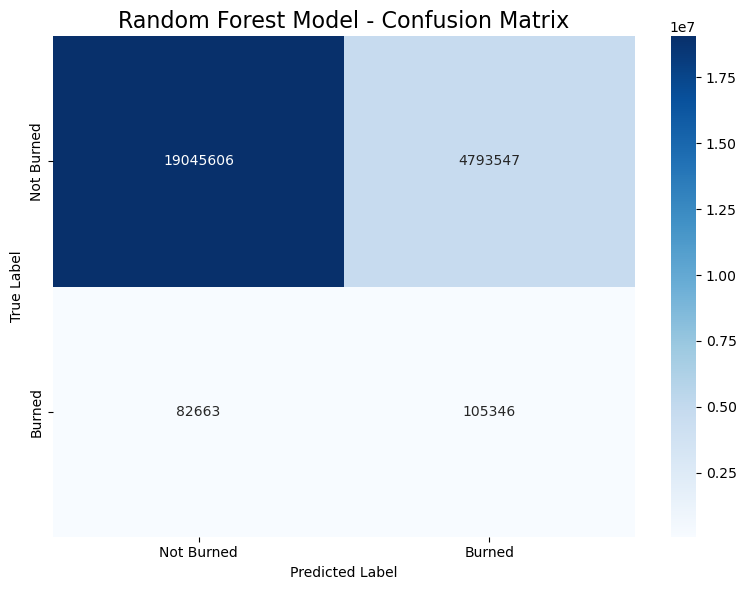

Complete Metric:
{'Accuracy': 0.7970542671664677, 'Balanced Accuracy': 0.6796227467085367, 'Recall': 0.5603242397970309, 'Precision': 0.02150404183149132, 'F1-Score': 0.04141852939175946, 'ROC-AUC': 0.750761334356592, 'Matthews Correlation Coefficient (MCC)': 0.07856683291474033, 'True Positives (TP)': 105346, 'False Positives (FP)': 4793547, 'True Negatives (TN)': 19045606, 'False Negatives (FN)': 82663, 'Support (Total Positive)': 188009, 'Support (Total Negative)': 23839153}


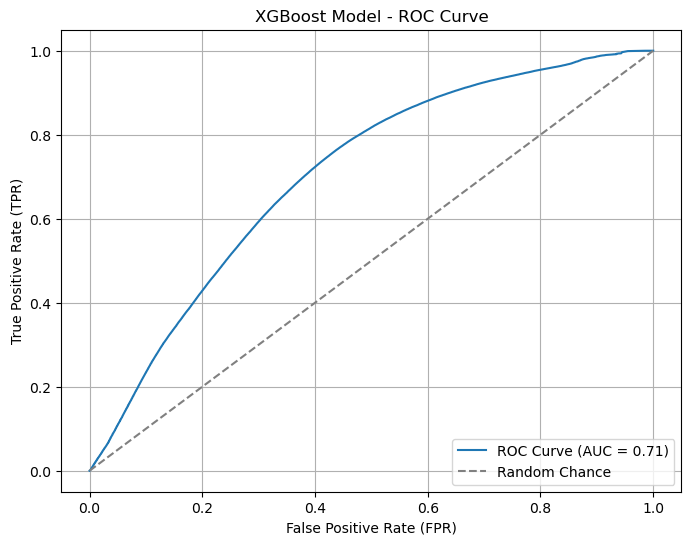

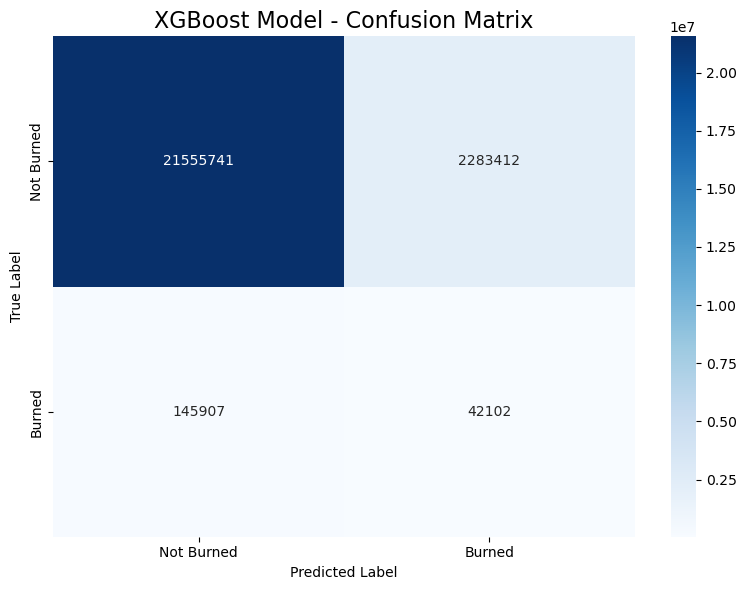

Complete Metric:
{'Accuracy': 0.8988928030701254, 'Balanced Accuracy': 0.5640759902000414, 'Recall': 0.22393608816599206, 'Precision': 0.018104384665067592, 'F1-Score': 0.033500389692077616, 'ROC-AUC': 0.7056356395167566, 'Matthews Correlation Coefficient (MCC)': 0.038190400735216484, 'True Positives (TP)': 42102, 'False Positives (FP)': 2283412, 'True Negatives (TN)': 21555741, 'False Negatives (FN)': 145907, 'Support (Total Positive)': 188009, 'Support (Total Negative)': 23839153}


C:\Users\Afonso Lavado\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


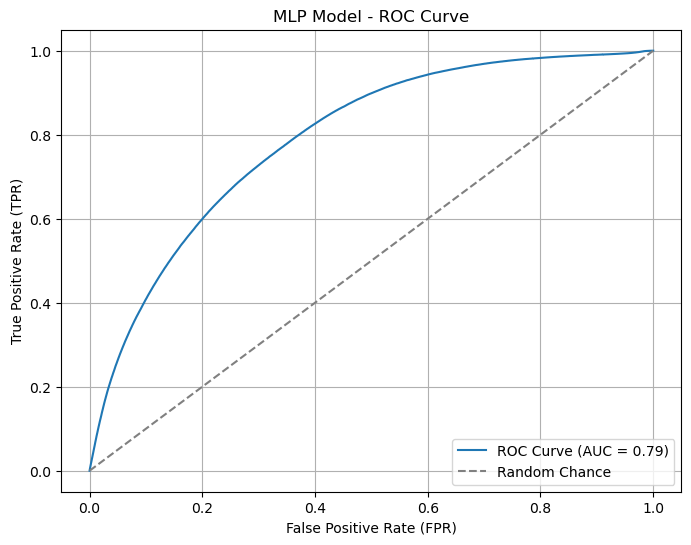

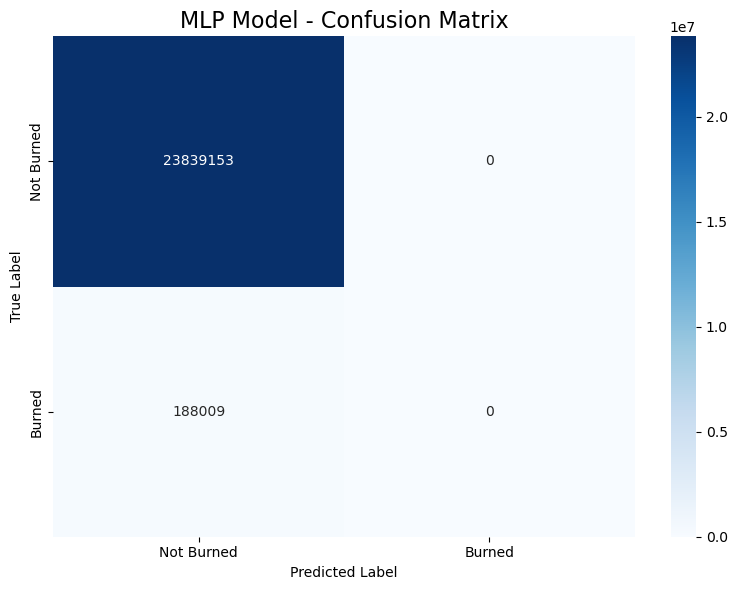

Complete Metric:
{'Accuracy': 0.9921751474435474, 'Balanced Accuracy': 0.5, 'Recall': 0.0, 'Precision': 0.0, 'F1-Score': 0.0, 'ROC-AUC': 0.7904101841207052, 'Matthews Correlation Coefficient (MCC)': 0.0, 'True Positives (TP)': 0, 'False Positives (FP)': 0, 'True Negatives (TN)': 23839153, 'False Negatives (FN)': 188009, 'Support (Total Positive)': 188009, 'Support (Total Negative)': 23839153}


In [17]:
# Example usage with your dataframe and models
true_label_column = 'Burned'

# Metrics and plots for Random Forest
rf_metrics_20230802 = calculate_metrics_with_plots(
    df_original_20230802, 'RF_Prob', true_label_column, plot_title="Random Forest Model"
)

# Metrics and plots for XGBoost
xgb_metrics_20230802 = calculate_metrics_with_plots(
    df_original_20230802, 'XGB_Prob', true_label_column, plot_title="XGBoost Model"
)

# Metrics and plots for MLP
mlp_metrics_20230802 = calculate_metrics_with_plots(
    df_original_20230802, 'MLP_Prob', true_label_column, plot_title="MLP Model"
)

In [18]:
# Save variables to pickle files
with open('rf_metrics_20230802.pkl', 'wb') as f:
    pickle.dump(rf_metrics_20230802, f)

with open('xgb_metrics_20230802.pkl', 'wb') as f:
    pickle.dump(xgb_metrics_20230802, f)

with open('mlp_metrics_20230802.pkl', 'wb') as f:
    pickle.dump(mlp_metrics_20230802, f)

In [17]:
# Replace commas with dots in the 'POINT_{X, Y, Z}' columns and convert to float
df_original_20230802['POINT_X'] = df_original_20230802['POINT_X'].str.replace(',', '.').astype(float)
df_original_20230802['POINT_Y'] = df_original_20230802['POINT_Y'].str.replace(',', '.').astype(float)
df_original_20230802['POINT_Z'] = df_original_20230802['POINT_Z'].str.replace(',', '.').astype(float)

In [18]:
df_original_20230802_results = df_original_20230802[['point_ID', 'POINT_X', 'POINT_Y', 'POINT_Z', 'RF_Prob', 'XGB_Prob', 'MLP_Prob', 'Burned']]

In [21]:
# Set Pandas display option to avoid scientific notation
pd.set_option('display.float_format', '{:.6f}'.format)

# Now run your describe function again
df_original_20230802_results.describe(include='all').T

count            mean            std            min  \
point_ID 24027162.000000 12093279.826767 6998747.355024       1.000000   
POINT_X  24027162.000000   -14369.476514   28539.141562  -77071.323672   
POINT_Y  24027162.000000  -242311.689883   29328.234549 -301405.439807   
POINT_Z  24027162.000000        0.000000       0.000000       0.000000   
RF_Prob  24027162.000000        0.273530       0.131732       0.005234   
XGB_Prob 24027162.000000        0.312624       0.071215       0.210153   
MLP_Prob 24027162.000000        0.282082       0.038195       0.136975   
Burned   24027162.000000        0.007825       0.088111       0.000000   

                    25%             50%             75%             max  
point_ID 6027067.250000 12077713.500000 18155443.750000 24480283.000000  
POINT_X   -38743.989994   -13580.030220    10759.139899    33609.515388  
POINT_Y  -267683.108609  -242729.736666  -216910.926446  -190772.794809  
POINT_Z        0.000000        0.000000        0.000000        0.000000  
RF_Prob        0.183980        0.289772        0.366905        0.510724  
XGB_Prob       0.264048        0.305805        0.359508        0.521340  
MLP_Prob       0.254235        0.282019        0.312589        0.373352  
Burned         0.000000        0.000000        0.000000        1.000000

In [19]:
# Group by 'COS18n1_L' and calculate the percentages using agg
result = df_original_20230802.groupby('COS18n1_L').agg(
    Burned_Percentage=('Burned', lambda x: (x.sum() / len(x)) * 100),  # Percentage of records actually burned
    RF_Prob=('RF_Prob', calculate_percentage),
    XGB_Prob=('XGB_Prob', calculate_percentage),
    MLP_Prob=('MLP_Prob', calculate_percentage),
    Total_Count=('point_ID', 'size'),
)

# Calculate Dataset percentage
total_records = len(df_original_20230802)
result['Dataset_Percentage'] = (result['Total_Count'] / total_records) * 100

result

Burned_Percentage    RF_Prob  \
COS18n1_L                                                                  
Agricultura                                          0.186648   2.143150   
Espaços descobertos ou com pouca vegetação           0.000000   1.072964   
Florestas                                            1.606044  38.200299   
Massas de água superficiais                          0.006237   2.567043   
Matos                                                1.026910  41.567917   
Pastagens                                            0.346440   3.025654   
Superfícies agroflorestais (SAF)                     0.003870   4.247428   
Territórios artificializados                         0.035311   1.487151   
Zonas húmidas                                        0.000000   4.328974   

                                             XGB_Prob  MLP_Prob  Total_Count  \
COS18n1_L                                                                      
Agricultura                                  2.151581       0.0      5788442   
Espaços descobertos ou com pouca vegetação   0.326554       0.0        79313   
Florestas                                   15.310124       0.0      8459481   
Massas de água superficiais                  0.977140       0.0       994023   
Matos                                       23.016829       0.0      3205246   
Pastagens                                    3.749549       0.0      2311798   
Superfícies agroflorestais (SAF)             2.933393       0.0      2273988   
Territórios artificializados                 0.487768       0.0       758968   
Zonas húmidas                                0.645914       0.0       155903   

                                            Dataset_Percentage  
COS18n1_L                                                       
Agricultura                                          24.091243  
Espaços descobertos ou com pouca vegetação            0.330097  
Florestas                                            35.207991  
Massas de água superficiais                           4.137080  
Matos                                                13.340094  
Pastagens                                             9.621602  
Superfícies agroflorestais (SAF)                      9.464239  
Territórios artificializados                          3.158792  
Zonas húmidas                                         0.648861

In [23]:
df_original_20230802_results.to_csv('df_20230802_results_V2.csv')

## 2.4: 2023 08 07 - Subset 1

In [12]:
file_path_20230807 = path+'TestData_20230807_V2.csv'

# Read the CSV file into a DataFrame
df_original_20230807 = pd.read_csv(file_path_20230807, sep=';')

In [13]:
# Define the columns to check
bands_columns = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B11', 'B12']
# Filter out rows where all specified bands are zero
df_original_20230807 = df_original_20230807[~(df_original_20230807[bands_columns].sum(axis=1) == 0)]

In [14]:
id_counts = df_original_20230807.groupby('point_ID').size().reset_index(name='count')
id_counts_more_than_one = id_counts[id_counts['count'] > 1]
id_counts_more_than_one.count()
duplicates = df_original_20230807[df_original_20230807['point_ID'].isin(id_counts_more_than_one['point_ID'])]
duplicates_sorted = duplicates.sort_values(by='point_ID')
indices_to_drop = duplicates_sorted.iloc[1::2].index
df_original_20230807 = df_original_20230807.drop(indices_to_drop)

# Display the DataFrame
df_original_20230807.sort_values(by='point_ID')

Burned   B02   B03   B04   B05   B06   B07   B08   B11   B12  \
4901852        0  1817  1809  1695  1699  1688  1711  1682  1627  1560   
4901853        0  1783  1779  1698  1684  1686  1691  1685  1625  1559   
4901854        0  1813  1821  1725  1732  1703  1750  1708  1637  1574   
4902474        0  1761  1767  1699  1760  1742  1773  1730  1672  1591   
4902475        0  1793  1800  1723  1758  1784  1757  1751  1681  1588   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
24336274       0  1497  1680  2023  2177  2254  2403  2449  2784  2517   
24336275       0  1549  1768  2106  2236  2381  2473  2535  2940  2663   
24336276       0  1536  1781  2115  2253  2370  2466  2517  2973  2678   
24336277       0  1548  1768  2098  2267  2367  2452  2532  3003  2712   
24336278       0  1582  1820  2191  2360  2453  2583  2635  3160  2851   

            Elevation      Slope       Aspect  point_ID  \
4901852           NaN        NaN          NaN         1   
4901853           NaN        NaN          NaN         2   
4901854           NaN        NaN          NaN         3   
4902474           NaN        NaN          NaN         4   
4902475           NaN        NaN          NaN         5   
...               ...        ...          ...       ...   
24336274  195,2555695  2,4598536  178,9616089  24480279   
24336275  195,0720673  2,8174024  145,0923157  24480280   
24336276  194,2091522  2,5088491  133,0476532  24480281   
24336277  194,1644592  0,8858909  167,7752838  24480282   
24336278  194,1644592  0,8858909  167,7752838  24480283   

                        POINT_X                  POINT_Y            POINT_Z  \
4901852   14336,670979054251802  -298929,298560334427748  0,000000000000000   
4901853   14356,676140243731425  -298929,480633034778293  0,000000000000000   
4901854   14376,681300671307326  -298929,662705731228925  0,000000000000000   
4902474   14296,842727491864935  -298908,929251822875813  0,000000000000000   
4902475   14316,847890194705542  -298909,111325296107680  0,000000000000000   
...                         ...                      ...                ...   
24336274  33529,497600165363110  -191691,043407764169388  0,000000000000000   
24336275  33549,502048283568001  -191691,229534869460622  0,000000000000000   
24336276  33569,506495652240119  -191691,415661968931090  0,000000000000000   
24336277  33589,510942268643703  -191691,601789066073252  0,000000000000000   
24336278  33609,515388135427202  -191691,787916158908047  0,000000000000000   

          COS18n1_C                    COS18n1_L  
4901852           9  Massas de água superficiais  
4901853           9  Massas de água superficiais  
4901854           9  Massas de água superficiais  
4902474           9  Massas de água superficiais  
4902475           9  Massas de água superficiais  
...             ...                          ...  
24336274          2                  Agricultura  
24336275          2                  Agricultura  
24336276          2                  Agricultura  
24336277          2                  Agricultura  
24336278          2                  Agricultura  

[24027162 rows x 19 columns]

In [13]:
# Count the number of 0s and 1s in the 'Burned' column
count_0 = (df_original_20230807['Burned'] == 0).sum()
count_1 = (df_original_20230807['Burned'] == 1).sum()

# Calculate the ratio of count_1 to count_0 as a percentage
ratio = (count_1 / count_0) * 100

# Print the counts and the ratio
print(f"Number of 0s: {count_0}")
print(f"Number of 1s: {count_1}")
print(f"Ratio of 1s to 0s: {ratio:.6f}%")

Number of 0s: 24022501
Number of 1s: 4661
Ratio of 1s to 0s: 0.019403%


In [14]:
df_original_20230807.describe(include='all').T

count    unique                      top      freq  \
Burned     24027162.0       NaN                      NaN       NaN   
B02        24027162.0       NaN                      NaN       NaN   
B03        24027162.0       NaN                      NaN       NaN   
B04        24027162.0       NaN                      NaN       NaN   
B05        24027162.0       NaN                      NaN       NaN   
B06        24027162.0       NaN                      NaN       NaN   
B07        24027162.0       NaN                      NaN       NaN   
B08        24027162.0       NaN                      NaN       NaN   
B11        24027162.0       NaN                      NaN       NaN   
B12        24027162.0       NaN                      NaN       NaN   
Elevation    23282193  11028249              123,8052902     39370   
Slope        23256513  12460560                0,0000000    120637   
Aspect       23252891  11093208               -1,0000000    120316   
point_ID   24027162.0       NaN                      NaN       NaN   
POINT_X      24027162  24027162   -73085,682897671838873         1   
POINT_Y      24027162  24027162  -297313,214448316197377         1   
POINT_Z      24027162         1        0,000000000000000  24027162   
COS18n1_C  24027162.0       NaN                      NaN       NaN   
COS18n1_L    24027162         9                Florestas   8459487   

                      mean             std     min         25%         50%  \
Burned            0.000194        0.013927     0.0         0.0         0.0   
B02            1829.824057      291.022215  1034.0      1620.0      1784.0   
B03            2104.344854      356.579858  1237.0      1833.0      2047.0   
B04            2378.641115      515.348197  1237.0      1958.0      2324.0   
B05            2676.134344      501.913194   942.0      2292.0      2622.0   
B06            3034.613894      460.783864  1218.0      2759.0      3014.0   
B07            3246.010965      501.969867  1174.0      2958.0      3234.0   
B08            3445.936824      536.201096  1103.0      3153.0      3451.0   
B11            4153.941141      981.703665  1215.0      3458.0      4115.0   
B12            3393.966107      947.412977  1011.0      2696.0      3337.0   
Elevation              NaN             NaN     NaN         NaN         NaN   
Slope                  NaN             NaN     NaN         NaN         NaN   
Aspect                 NaN             NaN     NaN         NaN         NaN   
point_ID   12093279.826767  6998747.355024     1.0  6027067.25  12077713.5   
POINT_X                NaN             NaN     NaN         NaN         NaN   
POINT_Y                NaN             NaN     NaN         NaN         NaN   
POINT_Z                NaN             NaN     NaN         NaN         NaN   
COS18n1_C         4.188786        1.833573     1.0         2.0         5.0   
COS18n1_L              NaN             NaN     NaN         NaN         NaN   

                   75%         max  
Burned             0.0         1.0  
B02             1980.0     19766.0  
B03             2309.0     18546.0  
B04             2727.0     17696.0  
B05             2997.0     17412.0  
B06             3299.0     17237.0  
B07             3536.0     17090.0  
B08             3765.0     17062.0  
B11             4898.0     16265.0  
B12             4069.0     16150.0  
Elevation          NaN         NaN  
Slope              NaN         NaN  
Aspect             NaN         NaN  
point_ID   18155443.75  24480283.0  
POINT_X            NaN         NaN  
POINT_Y            NaN         NaN  
POINT_Z            NaN         NaN  
COS18n1_C          5.0         9.0  
COS18n1_L          NaN         NaN

In [15]:
# Prepare the data
RF_df_20230807_subset_1_with_outliers_no_Aspect = process_wildfire_data(df_original_20230807, has_outliers=True, aspect_info='none', subset='subset_1')
XGB_df_20230807_subset_1_no_outliers_no_Aspect = process_wildfire_data(df_original_20230807, has_outliers=False, aspect_info='none', subset='subset_1')
MLP_df_20230807_subset_1_no_outliers_no_Aspect = process_wildfire_data(df_original_20230807, has_outliers=False, aspect_info='none', subset='subset_1')

In [16]:
RF_df_20230807_subset_1_with_outliers_no_Aspect = RF_df_20230807_subset_1_with_outliers_no_Aspect.drop(columns=['point_ID', 'POINT_X', 'POINT_Y', 'POINT_Z', 'Burned'])
XGB_df_20230807_subset_1_no_outliers_no_Aspect = XGB_df_20230807_subset_1_no_outliers_no_Aspect.drop(columns=['point_ID', 'POINT_X', 'POINT_Y', 'POINT_Z', 'Burned'])
MLP_df_20230807_subset_1_no_outliers_no_Aspect = MLP_df_20230807_subset_1_no_outliers_no_Aspect.drop(columns=['point_ID', 'POINT_X', 'POINT_Y', 'POINT_Z', 'Burned'])

In [17]:
# For Random Forest: rf_model_1_df_subset_1_no_Aspect_final
df_original_20230807['RF_Prob'] = rf_model_1_df_subset_1_no_Aspect_final.predict_proba(RF_df_20230807_subset_1_with_outliers_no_Aspect)[:, 1]

# For XGBoost: xgb_model_1_df_subset_1_NESW_final
df_original_20230807['XGB_Prob'] = xgb_model_1_df_subset_1_no_outliers_no_Aspect_final.predict_proba(XGB_df_20230807_subset_1_no_outliers_no_Aspect)[:, 1]

# For MLP: mlp_model_1_df_subset_1_no_outliers_no_Aspect_final
MLP_df_20230807_subset_1_no_outliers_no_Aspect_scaled = scaler_mlp_model_1_final.transform(MLP_df_20230807_subset_1_no_outliers_no_Aspect)
df_original_20230807['MLP_Prob'] = mlp_model_1_df_subset_1_no_outliers_no_Aspect_final.predict_proba(MLP_df_20230807_subset_1_no_outliers_no_Aspect_scaled)[:, 1]

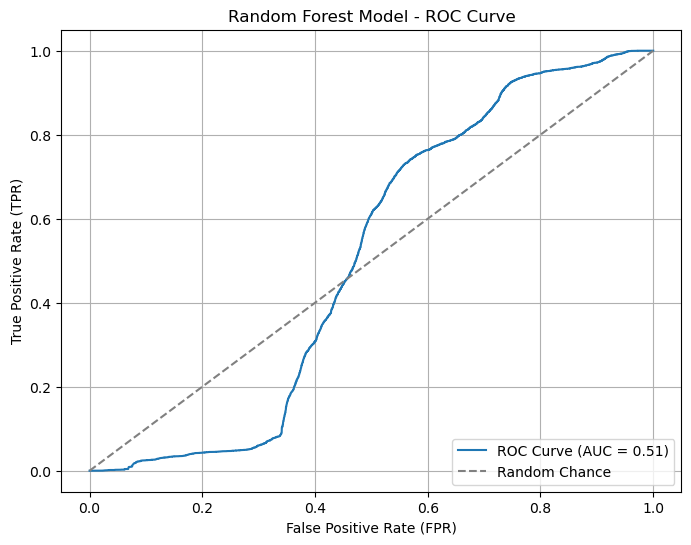

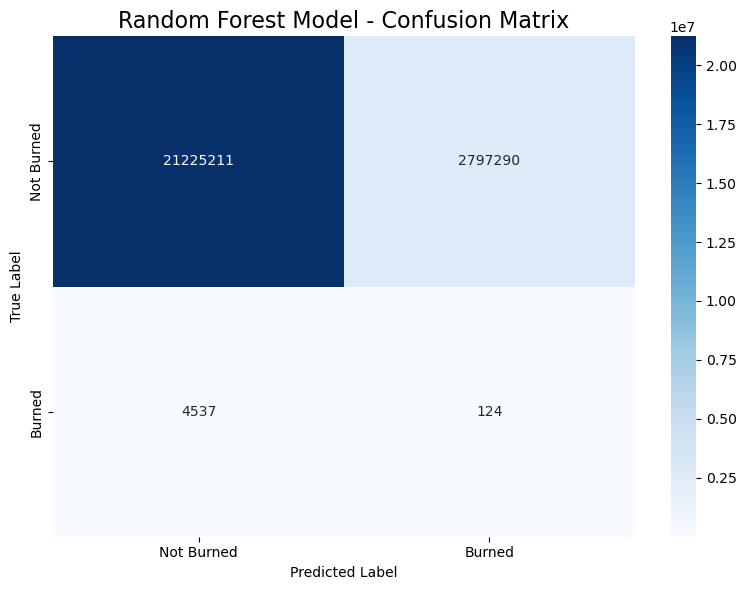

Complete Metric:
{'Accuracy': 0.8833891826258965, 'Balanced Accuracy': 0.45507957737427507, 'Recall (Sensitivity)': 0.026603733104484016, 'Precision': 4.432665311605647e-05, 'F1-Score': 8.850583942257078e-05, 'ROC-AUC': 0.5064656700223852, 'Matthews Correlation Coefficient (MCC)': -0.0039009618154409813, 'True Positives (TP)': 124, 'False Positives (FP)': 2797290, 'True Negatives (TN)': 21225211, 'False Negatives (FN)': 4537, 'Support (Total Positive)': 4661, 'Support (Total Negative)': 24022501}


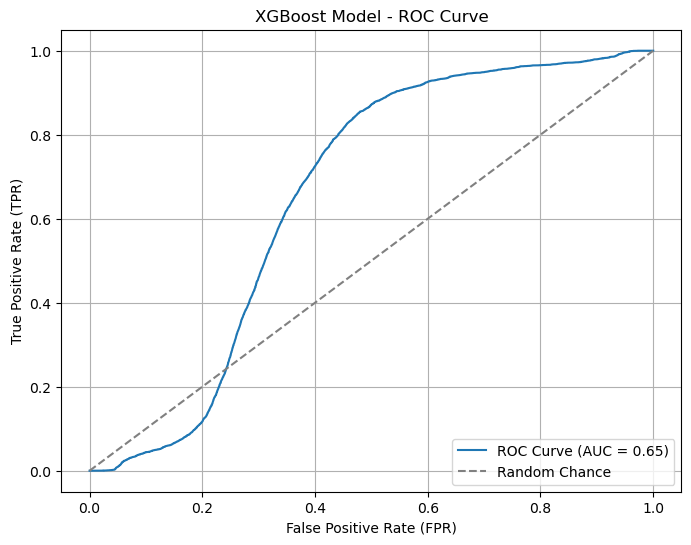

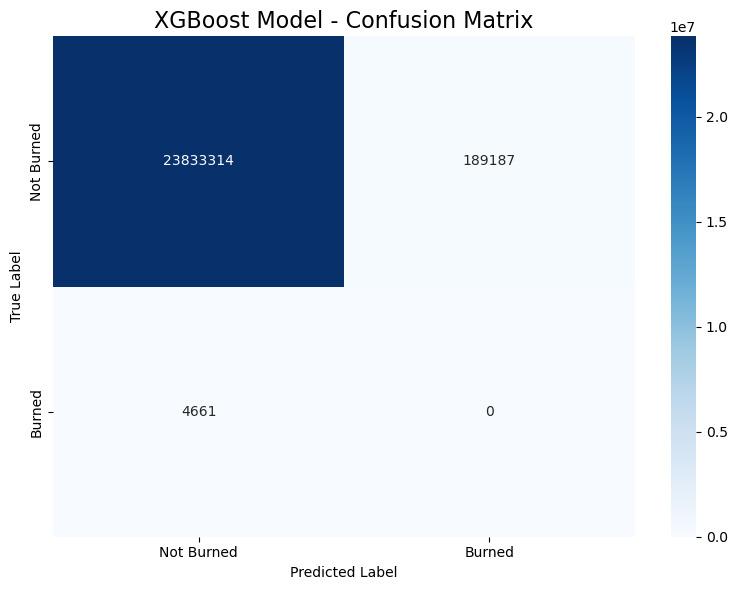

Complete Metric:
{'Accuracy': 0.9919321308109547, 'Balanced Accuracy': 0.49606229592830486, 'Recall (Sensitivity)': 0.0, 'Precision': 0.0, 'F1-Score': 0.0, 'ROC-AUC': 0.6549548570050602, 'Matthews Correlation Coefficient (MCC)': -0.0012409132067085396, 'True Positives (TP)': 0, 'False Positives (FP)': 189187, 'True Negatives (TN)': 23833314, 'False Negatives (FN)': 4661, 'Support (Total Positive)': 4661, 'Support (Total Negative)': 24022501}


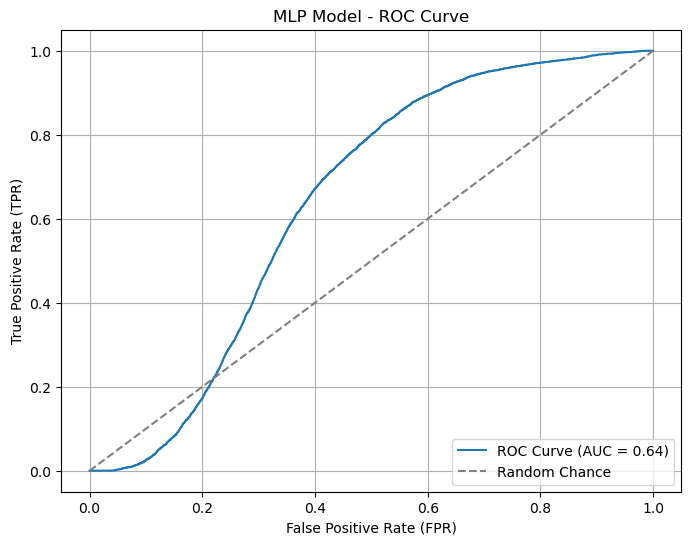

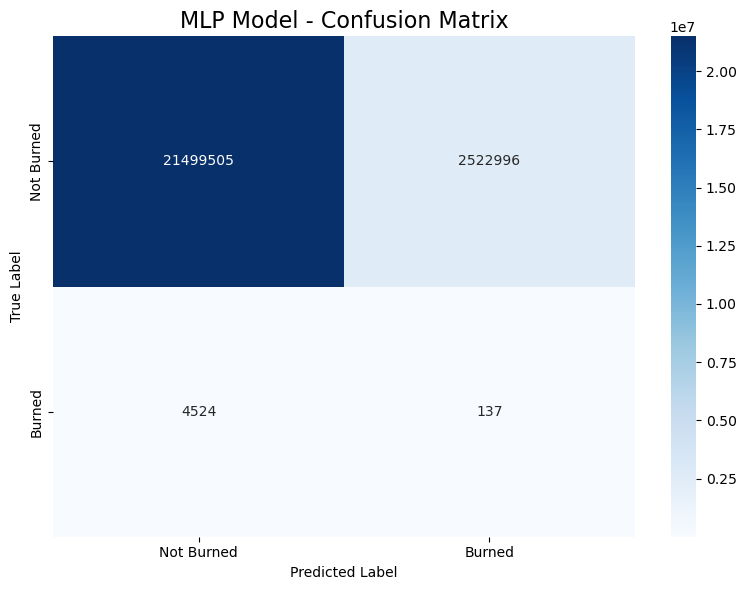

Complete Metric:
{'Accuracy': 0.8948057202927254, 'Balanced Accuracy': 0.46218323370867154, 'Recall (Sensitivity)': 0.029392834155760567, 'Precision': 5.429757369112131e-05, 'F1-Score': 0.00010839490876234376, 'ROC-AUC': 0.6408457188047338, 'Matthews Correlation Coefficient (MCC)': -0.003435840988683886, 'True Positives (TP)': 137, 'False Positives (FP)': 2522996, 'True Negatives (TN)': 21499505, 'False Negatives (FN)': 4524, 'Support (Total Positive)': 4661, 'Support (Total Negative)': 24022501}


In [20]:
# Example usage with your dataframe and models
true_label_column = 'Burned'

# Metrics and plots for Random Forest
rf_metrics_20230807 = calculate_metrics_with_plots(
    df_original_20230807, 'RF_Prob', true_label_column, plot_title="Random Forest Model"
)

# Metrics and plots for XGBoost
xgb_metrics_20230807 = calculate_metrics_with_plots(
    df_original_20230807, 'XGB_Prob', true_label_column, plot_title="XGBoost Model"
)

# Metrics and plots for MLP
mlp_metrics_20230807 = calculate_metrics_with_plots(
    df_original_20230807, 'MLP_Prob', true_label_column, plot_title="MLP Model"
)

In [21]:
# Save variables to pickle files
with open('rf_metrics_20230807.pkl', 'wb') as f:
    pickle.dump(rf_metrics_20230807, f)

with open('xgb_metrics_20230807.pkl', 'wb') as f:
    pickle.dump(xgb_metrics_20230807, f)

with open('mlp_metrics_20230807.pkl', 'wb') as f:
    pickle.dump(mlp_metrics_20230807, f)

In [18]:
# Replace commas with dots in the 'POINT_X' column and convert to float
df_original_20230807['POINT_X'] = df_original_20230807['POINT_X'].str.replace(',', '.').astype(float)
df_original_20230807['POINT_Y'] = df_original_20230807['POINT_Y'].str.replace(',', '.').astype(float)
df_original_20230807['POINT_Z'] = df_original_20230807['POINT_Z'].str.replace(',', '.').astype(float)

In [19]:
df_original_20230807_results = df_original_20230807[['point_ID', 'POINT_X', 'POINT_Y', 'POINT_Z', 'RF_Prob', 'XGB_Prob', 'MLP_Prob', 'Burned']]

In [24]:
# Set Pandas display option to avoid scientific notation
pd.set_option('display.float_format', '{:.6f}'.format)

# Now run your describe function again
df_original_20230807_results.describe(include='all').T

count            mean            std            min  \
point_ID 24027162.000000 12093279.826767 6998747.355024       1.000000   
POINT_X  24027162.000000   -14369.476514   28539.141562  -77071.323672   
POINT_Y  24027162.000000  -242311.689883   29328.234549 -301405.439807   
POINT_Z  24027162.000000        0.000000       0.000000       0.000000   
RF_Prob  24027162.000000        0.234464       0.111827       0.014679   
XGB_Prob 24027162.000000        0.297383       0.066660       0.236295   
MLP_Prob 24027162.000000        0.210043       0.126705       0.000000   
Burned   24027162.000000        0.000194       0.013927       0.000000   

                    25%             50%             75%             max  
point_ID 6027067.250000 12077713.500000 18155443.750000 24480283.000000  
POINT_X   -38743.989994   -13580.030220    10759.139899    33609.515388  
POINT_Y  -267683.108609  -242729.736666  -216910.926446  -190772.794809  
POINT_Z        0.000000        0.000000        0.000000        0.000000  
RF_Prob        0.145308        0.209571        0.330467        0.453133  
XGB_Prob       0.263643        0.285142        0.329440        0.454129  
MLP_Prob       0.115081        0.170129        0.282385        0.997535  
Burned         0.000000        0.000000        0.000000        1.000000

In [20]:
# Group by 'COS18n1_L' and calculate the percentages using agg
result = df_original_20230807.groupby('COS18n1_L').agg(
    Burned_Percentage=('Burned', lambda x: (x.sum() / len(x)) * 100),  # Percentage of records actually burned
    RF_Prob=('RF_Prob', calculate_percentage),
    XGB_Prob=('XGB_Prob', calculate_percentage),
    MLP_Prob=('MLP_Prob', calculate_percentage),
    Total_Count=('point_ID', 'size'),
)

# Calculate Dataset percentage
total_records = len(df_original_20230807)
result['Dataset_Percentage'] = (result['Total_Count'] / total_records) * 100

result

Burned_Percentage    RF_Prob  \
COS18n1_L                                                                  
Agricultura                                          0.001589   1.200148   
Espaços descobertos ou com pouca vegetação           0.000000   0.844744   
Florestas                                            0.018961  24.691237   
Massas de água superficiais                          0.000000   0.472025   
Matos                                                0.085548  18.917377   
Pastagens                                            0.009646   0.319447   
Superfícies agroflorestais (SAF)                     0.000000   0.805678   
Territórios artificializados                         0.000000   0.234268   
Zonas húmidas                                        0.000000   0.000000   

                                            XGB_Prob   MLP_Prob  Total_Count  \
COS18n1_L                                                                      
Agricultura                                 0.112776   0.549404      5788454   
Espaços descobertos ou com pouca vegetação  0.317724   1.187684        79314   
Florestas                                   1.866922  22.450321      8459487   
Massas de água superficiais                 0.007042   0.225550       994016   
Matos                                       0.756232  17.607269      3205233   
Pastagens                                   0.001903   0.175663      2311810   
Superfícies agroflorestais (SAF)            0.000792   0.830261      2273984   
Territórios artificializados                0.013703   0.219247       758960   
Zonas húmidas                               0.000000   0.003849       155904   

                                            Dataset_Percentage  
COS18n1_L                                                       
Agricultura                                          24.091293  
Espaços descobertos ou com pouca vegetação            0.330101  
Florestas                                            35.208016  
Massas de água superficiais                           4.137051  
Matos                                                13.340040  
Pastagens                                             9.621652  
Superfícies agroflorestais (SAF)                      9.464222  
Territórios artificializados                          3.158758  
Zonas húmidas                                         0.648866

In [26]:
df_original_20230807_results.to_csv('df_original_20230807_results_V2.csv')

## 2.5: 2023 10 01 - Subset 1

In [11]:
file_path_20231001 = path+'TestData_20231001_V2.csv'

# Read the CSV file into a DataFrame
df_original_20231001 = pd.read_csv(file_path_20231001, sep=';')

In [12]:
# Define the columns to check
bands_columns = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B11', 'B12']
# Filter out rows where all specified bands are zero
df_original_20231001 = df_original_20231001[~(df_original_20231001[bands_columns].sum(axis=1) == 0)]

In [13]:
id_counts = df_original_20231001.groupby('point_ID').size().reset_index(name='count')
id_counts_more_than_one = id_counts[id_counts['count'] > 1]
id_counts_more_than_one.count()
duplicates = df_original_20231001[df_original_20231001['point_ID'].isin(id_counts_more_than_one['point_ID'])]
duplicates_sorted = duplicates.sort_values(by='point_ID')
indices_to_drop = duplicates_sorted.iloc[1::2].index
df_original_20230807 = df_original_20231001.drop(indices_to_drop)

# Display the DataFrame
df_original_20231001.sort_values(by='point_ID')

Burned   B02   B03   B04   B05   B06   B07   B08   B11   B12  \
5872183        0  1301  1292  1102  1078  1061  1066  1050  1045  1047   
5872184        0  1311  1282  1093  1082  1058  1063  1073  1053  1046   
5872185        0  1303  1307  1115  1096  1065  1061  1059  1058  1051   
5872560        0  1305  1277  1086  1078  1053  1066  1046  1044  1040   
5872561        0  1308  1271  1072  1082  1052  1056  1035  1045  1038   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
24449587       0  1254  1425  1749  1840  1864  1933  1983  2383  2210   
24449588       0  1310  1510  1822  1944  2008  2067  2083  2553  2356   
24449589       0  1332  1521  1838  1953  1977  2043  2093  2614  2408   
24449590       0  1312  1499  1801  1936  1942  2028  2082  2671  2428   
24449591       0  1315  1537  1909  2047  2108  2146  2186  2815  2556   

            Elevation      Slope       Aspect  point_ID  \
5872183           NaN        NaN          NaN         1   
5872184           NaN        NaN          NaN         2   
5872185           NaN        NaN          NaN         3   
5872560           NaN        NaN          NaN         4   
5872561           NaN        NaN          NaN         5   
...               ...        ...          ...       ...   
24449587  195,2555695  2,4598536  178,9616089  24480279   
24449588  195,0720673  2,8174024  145,0923157  24480280   
24449589  194,2091522  2,5088491  133,0476532  24480281   
24449590  194,1644592  0,8858909  167,7752838  24480282   
24449591  194,1644592  0,8858909  167,7752838  24480283   

                        POINT_X                  POINT_Y            POINT_Z  \
5872183   14336,670979054251802  -298929,298560334427748  0,000000000000000   
5872184   14356,676140243731425  -298929,480633034778293  0,000000000000000   
5872185   14376,681300674137674  -298929,662705730530433  0,000000000000000   
5872560   14296,842727491864935  -298908,929251822875813  0,000000000000000   
5872561   14316,847890194705542  -298909,111325296107680  0,000000000000000   
...                         ...                      ...                ...   
24449587  33529,497600165486801  -191691,043407759221736  0,000000000000000   
24449588  33549,502048283815384  -191691,229534863086883  0,000000000000000   
24449589  33569,506495652225567  -191691,415661963983439  0,000000000000000   
24449590  33589,510942271699605  -191691,601789061125601  0,000000000000000   
24449591  33609,515388135405374  -191691,787916153232800  0,000000000000000   

          COS18n1_C                    COS18n1_L  
5872183           9  Massas de água superficiais  
5872184           9  Massas de água superficiais  
5872185           9  Massas de água superficiais  
5872560           9  Massas de água superficiais  
5872561           9  Massas de água superficiais  
...             ...                          ...  
24449587          2                  Agricultura  
24449588          2                  Agricultura  
24449589          2                  Agricultura  
24449590          2                  Agricultura  
24449591          2                  Agricultura  

[24027573 rows x 19 columns]

In [14]:
# Count the number of 0s and 1s in the 'Burned' column
count_0 = (df_original_20231001['Burned'] == 0).sum()
count_1 = (df_original_20231001['Burned'] == 1).sum()

# Calculate the ratio of count_1 to count_0 as a percentage
ratio = (count_1 / count_0) * 100

# Print the counts and the ratio
print(f"Number of 0s: {count_0}")
print(f"Number of 1s: {count_1}")
print(f"Ratio of 1s to 0s: {ratio:.6f}%")

Number of 0s: 24024620
Number of 1s: 2953
Ratio of 1s to 0s: 0.012292%


In [15]:
df_original_20231001.describe(include='all').T

count    unique                      top      freq  \
Burned     24027573.0       NaN                      NaN       NaN   
B02        24027573.0       NaN                      NaN       NaN   
B03        24027573.0       NaN                      NaN       NaN   
B04        24027573.0       NaN                      NaN       NaN   
B05        24027573.0       NaN                      NaN       NaN   
B06        24027573.0       NaN                      NaN       NaN   
B07        24027573.0       NaN                      NaN       NaN   
B08        24027573.0       NaN                      NaN       NaN   
B11        24027573.0       NaN                      NaN       NaN   
B12        24027573.0       NaN                      NaN       NaN   
Elevation    23282600  11028249              123,8052902     39371   
Slope        23256920  12460560                0,0000000    120638   
Aspect       23253298  11093208               -1,0000000    120317   
point_ID   24027573.0       NaN                      NaN       NaN   
POINT_X      24027573  24027162   -11515,611568146234276         2   
POINT_Y      24027573  24027162  -196994,185578621516470         2   
POINT_Z      24027573         1        0,000000000000000  24027573   
COS18n1_C  24027573.0       NaN                      NaN       NaN   
COS18n1_L    24027573         9                Florestas   8459604   

                      mean            std     min        25%         50%  \
Burned            0.000123       0.011085     0.0        0.0         0.0   
B02             1553.68741     309.242492   979.0     1328.0      1493.0   
B03            1807.850495     396.424513  1012.0     1507.0      1732.0   
B04            2041.913928     566.469072  1013.0     1590.0      1963.0   
B05             2310.46751     567.983494   920.0     1893.0      2234.0   
B06            2668.425775     530.112423   763.0     2373.0      2640.0   
B07            2837.093475     559.603203   850.0     2535.0      2821.0   
B08             3023.16422      586.15514   838.0     2720.0      3025.0   
B11            3775.515343    1036.382709   972.0     3047.0      3730.0   
B12            3097.360047     962.503521   982.0     2356.0      3029.0   
Elevation              NaN            NaN     NaN        NaN         NaN   
Slope                  NaN            NaN     NaN        NaN         NaN   
Aspect                 NaN            NaN     NaN        NaN         NaN   
point_ID   12093269.728403  6998748.93936     1.0  6027053.0  12077698.0   
POINT_X                NaN            NaN     NaN        NaN         NaN   
POINT_Y                NaN            NaN     NaN        NaN         NaN   
POINT_Z                NaN            NaN     NaN        NaN         NaN   
COS18n1_C         4.188783       1.833574     1.0        2.0         5.0   
COS18n1_L              NaN            NaN     NaN        NaN         NaN   

                  75%         max  
Burned            0.0         1.0  
B02            1720.0     18825.0  
B03            2033.0     17845.0  
B04            2413.0     14818.0  
B05            2661.0     16288.0  
B06            2951.0     16815.0  
B07            3140.0     16718.0  
B08            3349.0     16567.0  
B11            4561.0     16136.0  
B12            3832.0     16073.0  
Elevation         NaN         NaN  
Slope             NaN         NaN  
Aspect            NaN         NaN  
point_ID   18155442.0  24480283.0  
POINT_X           NaN         NaN  
POINT_Y           NaN         NaN  
POINT_Z           NaN         NaN  
COS18n1_C         5.0         9.0  
COS18n1_L         NaN         NaN

In [16]:
# Prepare the data
# RF_df_20231001_subset_1_with_outliers_no_Aspect = process_wildfire_data(df_original_20231001, has_outliers=True, aspect_info='none', subset='subset_1')
# XGB_df_20231001_subset_1_no_outliers_no_Aspect = process_wildfire_data(df_original_20231001, has_outliers=False, aspect_info='none', subset='subset_1')
MLP_df_20231001_subset_1_no_outliers_no_Aspect = process_wildfire_data(df_original_20231001, has_outliers=False, aspect_info='none', subset='subset_1')

In [17]:
# RF_df_20231001_subset_1_with_outliers_no_Aspect = RF_df_20231001_subset_1_with_outliers_no_Aspect.drop(columns=['point_ID', 'POINT_X', 'POINT_Y', 'POINT_Z', 'Burned'])
# XGB_df_20231001_subset_1_no_outliers_no_Aspect = XGB_df_20231001_subset_1_no_outliers_no_Aspect.drop(columns=['point_ID', 'POINT_X', 'POINT_Y', 'POINT_Z', 'Burned'])
MLP_df_20231001_subset_1_no_outliers_no_Aspect = MLP_df_20231001_subset_1_no_outliers_no_Aspect.drop(columns=['point_ID', 'POINT_X', 'POINT_Y', 'POINT_Z', 'Burned'])

In [ ]:
# For Random Forest: rf_model_1_df_subset_1_no_Aspect_final
df_original_20231001['RF_Prob'] = rf_model_1_df_subset_1_no_Aspect_final.predict_proba(RF_df_20231001_subset_1_with_outliers_no_Aspect)[:, 1]

# For XGBoost: xgb_model_1_df_subset_1_NESW_final
# df_original_20231001['XGB_Prob'] = xgb_model_1_df_subset_1_no_outliers_no_Aspect_final.predict_proba(XGB_df_20231001_subset_1_no_outliers_no_Aspect)[:, 1]

# For MLP: mlp_model_1_df_subset_1_no_outliers_no_Aspect_final
MLP_df_20231001_subset_1_no_outliers_no_Aspect_scaled = scaler_mlp_model_1_final.transform(MLP_df_20231001_subset_1_no_outliers_no_Aspect)
df_original_20231001['MLP_Prob'] = mlp_model_1_df_subset_1_no_outliers_no_Aspect_final.predict_proba(MLP_df_20231001_subset_1_no_outliers_no_Aspect_scaled)[:, 1]

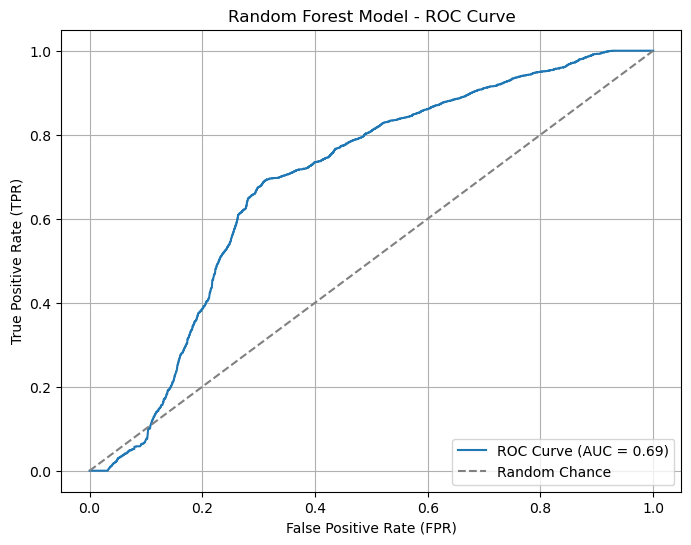

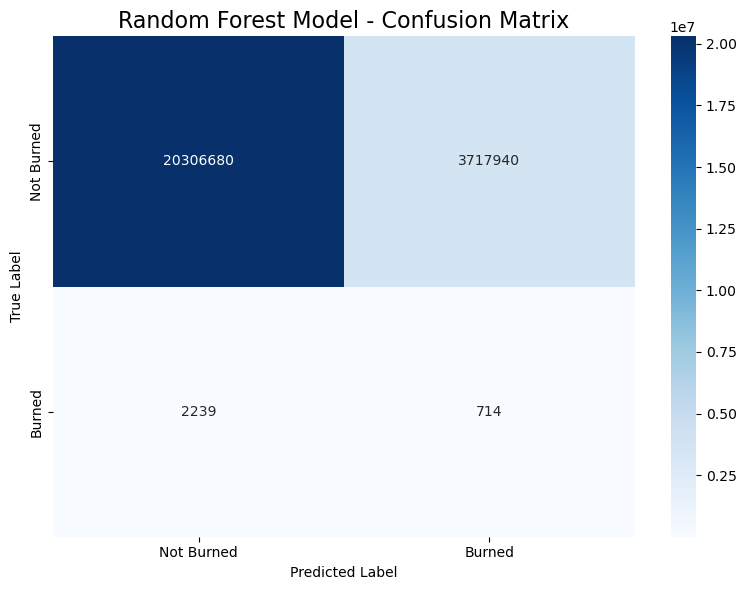

Complete Metric:
{'Accuracy': 0.8451704214986674, 'Balanced Accuracy': 0.5435162993929552, 'Recall (Sensitivity)': 0.24178801219099222, 'Precision': 0.00019200495663215775, 'F1-Score': 0.0003837052112165524, 'ROC-AUC': 0.6907385434357712, 'Matthews Correlation Coefficient (MCC)': 0.002667507500450079, 'True Positives (TP)': 714, 'False Positives (FP)': 3717940, 'True Negatives (TN)': 20306680, 'False Negatives (FN)': 2239, 'Support (Total Positive)': 2953, 'Support (Total Negative)': 24024620}


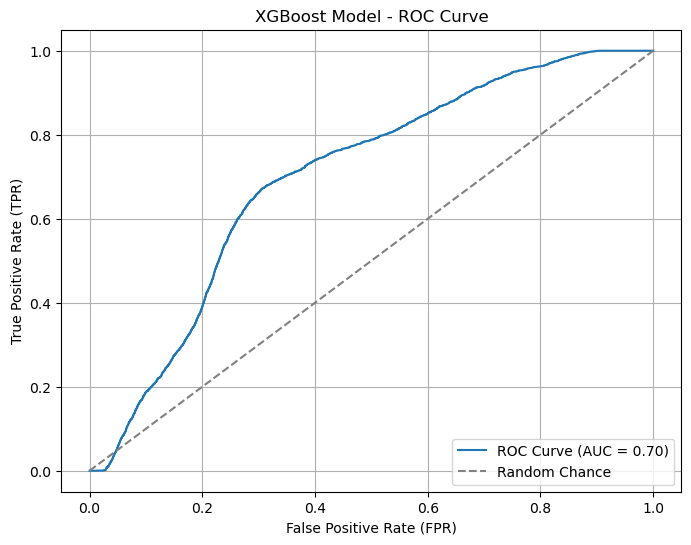

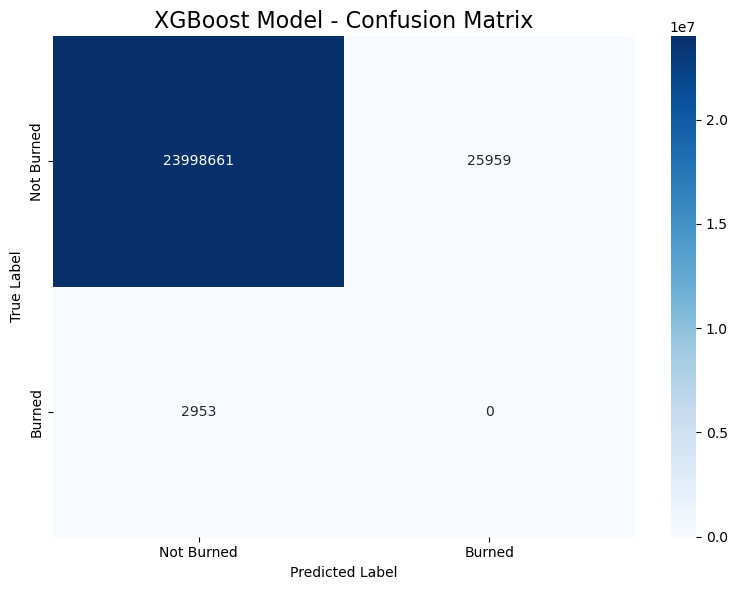

Complete Metric:
{'Accuracy': 0.9987967157565185, 'Balanced Accuracy': 0.4994597417149574, 'Recall (Sensitivity)': 0.0, 'Precision': 0.0, 'F1-Score': 0.0, 'ROC-AUC': 0.6994931430811544, 'Matthews Correlation Coefficient (MCC)': -0.0003646088581683436, 'True Positives (TP)': 0, 'False Positives (FP)': 25959, 'True Negatives (TN)': 23998661, 'False Negatives (FN)': 2953, 'Support (Total Positive)': 2953, 'Support (Total Negative)': 24024620}


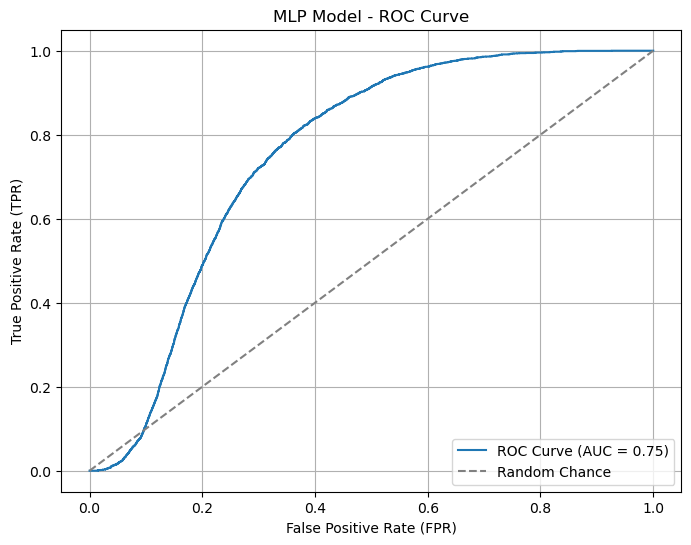

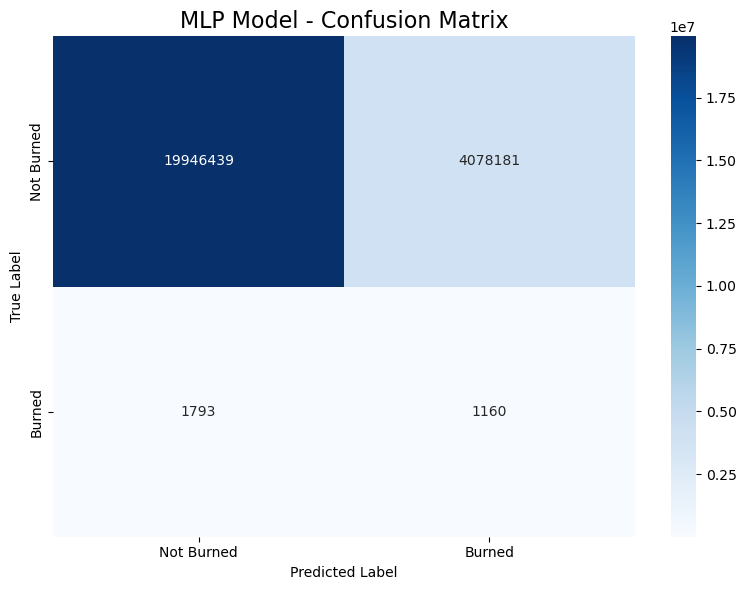

Complete Metric:
{'Accuracy': 0.8301961667123018, 'Balanced Accuracy': 0.6115353935460827, 'Recall (Sensitivity)': 0.3928208601422282, 'Precision': 0.00028435965515018235, 'F1-Score': 0.0005683079170681974, 'ROC-AUC': 0.7522914581842819, 'Matthews Correlation Coefficient (MCC)': 0.00658651183151482, 'True Positives (TP)': 1160, 'False Positives (FP)': 4078181, 'True Negatives (TN)': 19946439, 'False Negatives (FN)': 1793, 'Support (Total Positive)': 2953, 'Support (Total Negative)': 24024620}


In [19]:
# Example usage with your dataframe and models
true_label_column = 'Burned'

# Metrics and plots for Random Forest
rf_metrics_20231001 = calculate_metrics_with_plots(
    df_original_20231001, 'RF_Prob', true_label_column, plot_title="Random Forest Model"
)

# Metrics and plots for XGBoost
xgb_metrics_20231001 = calculate_metrics_with_plots(
    df_original_20231001, 'XGB_Prob', true_label_column, plot_title="XGBoost Model"
)

# Metrics and plots for MLP
mlp_metrics_20231001 = calculate_metrics_with_plots(
    df_original_20231001, 'MLP_Prob', true_label_column, plot_title="MLP Model"
)

In [20]:
# Save variables to pickle files
with open('rf_metrics_20231001.pkl', 'wb') as f:
    pickle.dump(rf_metrics_20231001, f)

with open('xgb_metrics_20231001.pkl', 'wb') as f:
    pickle.dump(xgb_metrics_20231001, f)

with open('mlp_metrics_20231001.pkl', 'wb') as f:
    pickle.dump(mlp_metrics_20231001, f)

In [19]:
# Replace commas with dots in the 'POINT_X' column and convert to float
df_original_20231001['POINT_X'] = df_original_20231001['POINT_X'].str.replace(',', '.').astype(float)
df_original_20231001['POINT_Y'] = df_original_20231001['POINT_Y'].str.replace(',', '.').astype(float)
df_original_20231001['POINT_Z'] = df_original_20231001['POINT_Z'].str.replace(',', '.').astype(float)

In [18]:
MLP_df_20231001_subset_1_no_outliers_no_Aspect_scaled = scaler_mlp_model_1_final.transform(MLP_df_20231001_subset_1_no_outliers_no_Aspect)
MLP_df_20231001_subset_1_no_outliers_no_Aspect['MLP_Prob'] = mlp_model_1_df_subset_1_no_outliers_no_Aspect_final.predict_proba(MLP_df_20231001_subset_1_no_outliers_no_Aspect_scaled)[:, 1]

In [19]:
# Creating the 'Burned_Pred' column based on the MLP_Prob threshold
MLP_df_20231001_subset_1_no_outliers_no_Aspect['Burned_Pred'] = (MLP_df_20231001_subset_1_no_outliers_no_Aspect['MLP_Prob'] >= 0.4).astype(int)

In [18]:
MLP_df_20231001_subset_1_no_outliers_no_Aspect

B03   B04   B06   B12  Elevation     Slope      NDWI       GCI  \
0         1247  1162  1138  1086   0.000000  0.000000  0.047899 -0.091419   
1         1229  1133  1111  1075   0.000000  0.000000  0.046403 -0.088690   
2         1233  1132  1106  1087   0.000000  0.000000  0.053846 -0.102190   
3         1261  1155  1128  1088   0.000000  0.000000  0.057886 -0.109437   
4         1240  1139  1126  1081   0.000000  0.000000  0.050847 -0.096774   
...        ...   ...   ...   ...        ...       ...       ...       ...   
24485015  1431  1668  2187  2549  67.754654  0.150754 -0.297669  0.847659   
24485016  1455  1688  2172  2639  67.768784  0.150754 -0.299302  0.854296   
24485017  1463  1706  2182  2664  67.709488  0.302727 -0.293237  0.829802   
24485018  1462  1723  2158  2756  67.595383  0.390193 -0.284561  0.795486   
24485019  1461  1730  2171  2747  67.619949  0.547635 -0.289051  0.813142   

               ARI    MSAVI2       BSI       NBR  MLP_Prob  Burned_Pred  
0        -0.000072 -0.025584 -0.033617  0.021181  0.082878            0  
1        -0.000070 -0.011602 -0.046147  0.020501  0.084617            0  
2        -0.000078 -0.022573 -0.041397  0.009116  0.077606            0  
3        -0.000084 -0.028482 -0.037668  0.015830  0.082430            0  
4        -0.000072 -0.016957 -0.038197  0.017719  0.087963            0  
...            ...       ...       ...       ...       ...          ...  
24485015  0.000176  0.369094  0.113449  0.018294  0.199940            0  
24485016  0.000173  0.374308  0.111634  0.011055  0.189910            0  
24485017  0.000173  0.362676  0.119588  0.002434  0.186502            0  
24485018  0.000178  0.343576  0.134142 -0.024345  0.164905            0  
24485019  0.000185  0.346881  0.137432 -0.018162  0.176245            0  

[24027573 rows x 14 columns]

In [20]:
target_variable = 'MLP_Prob'

features = MLP_df_20231001_subset_1_no_outliers_no_Aspect.drop(target_variable, axis=1)  # Exclude the target variable
target = MLP_df_20231001_subset_1_no_outliers_no_Aspect[target_variable]

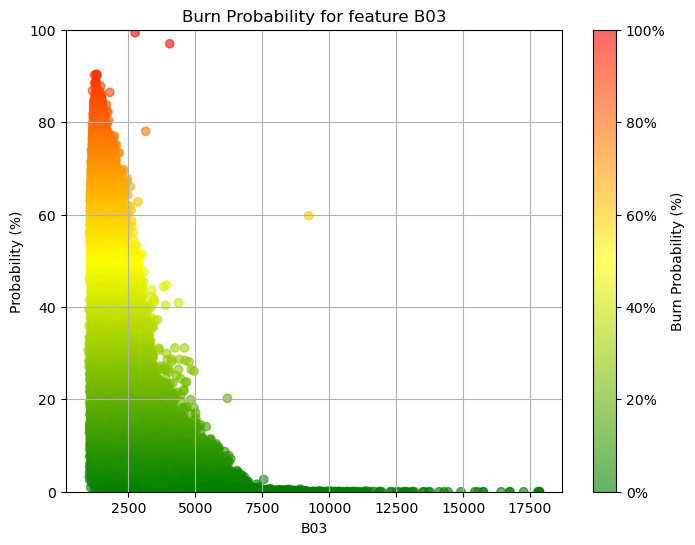

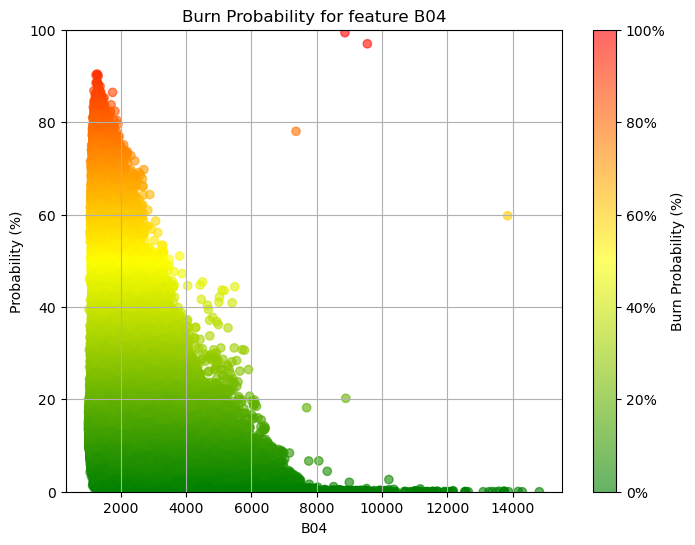

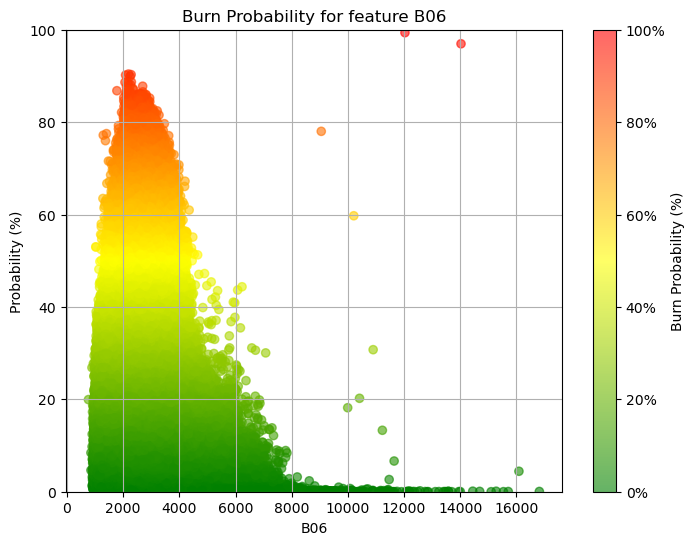

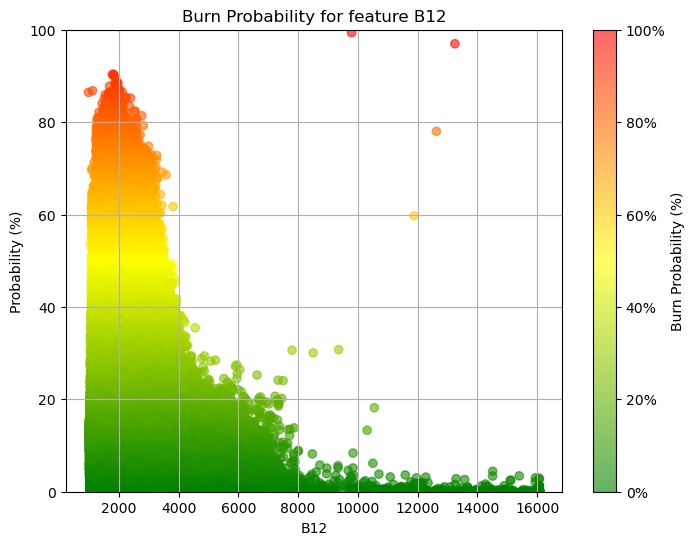

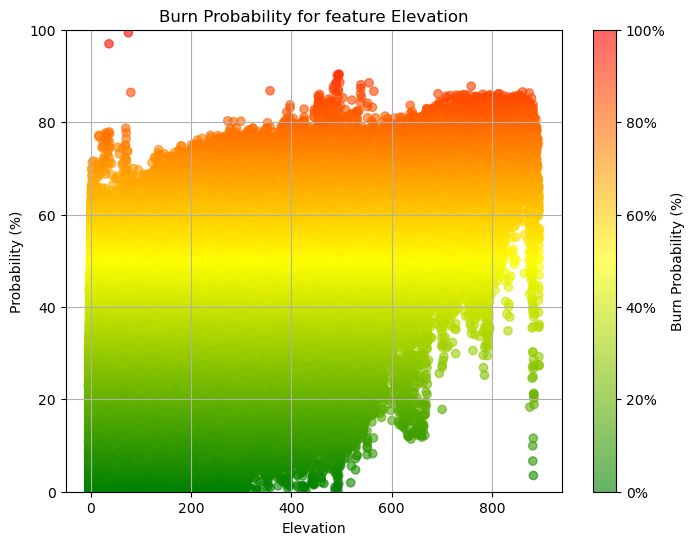

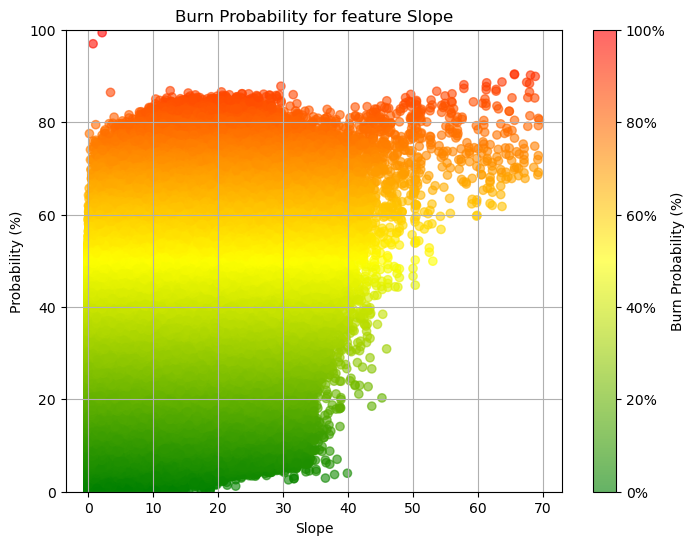

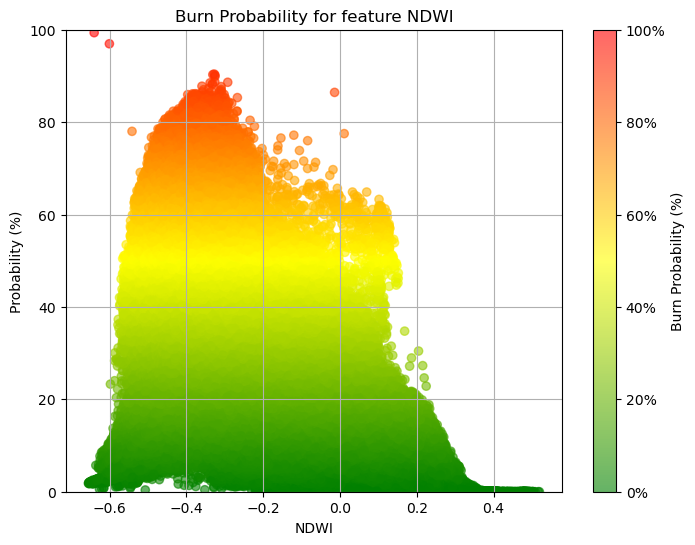

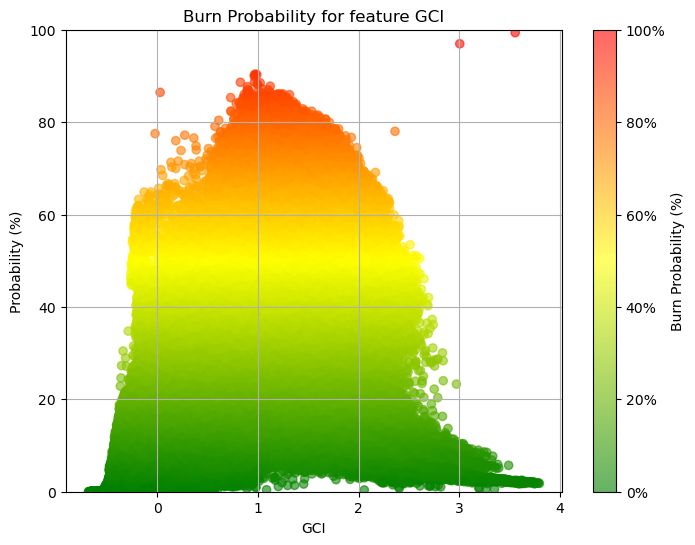

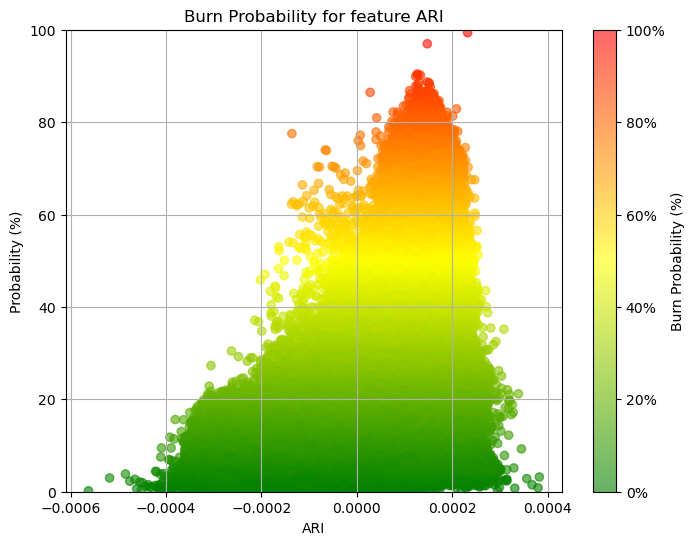

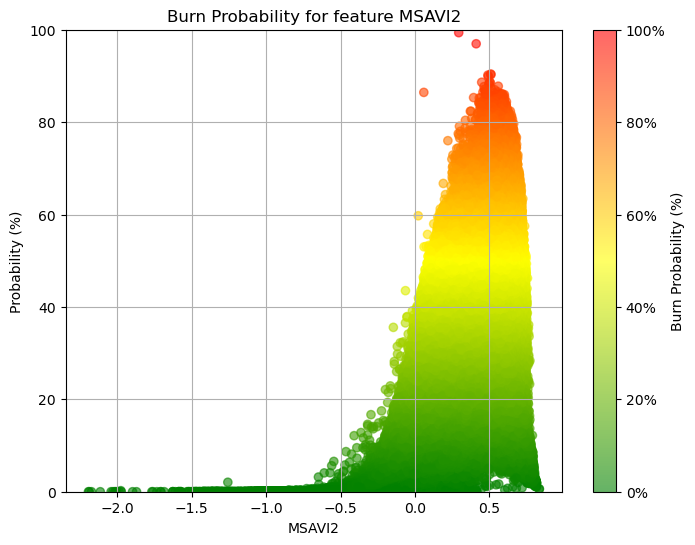

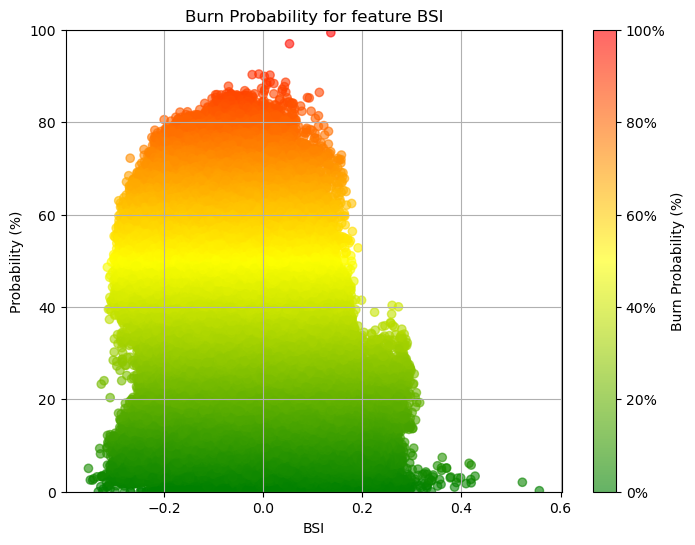

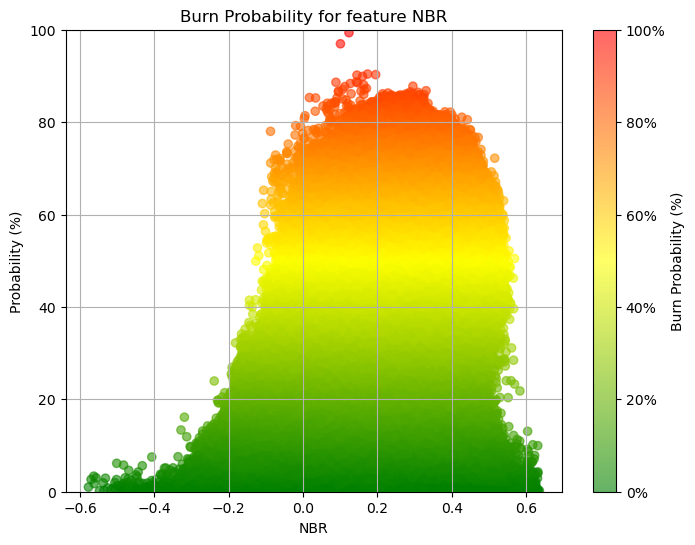

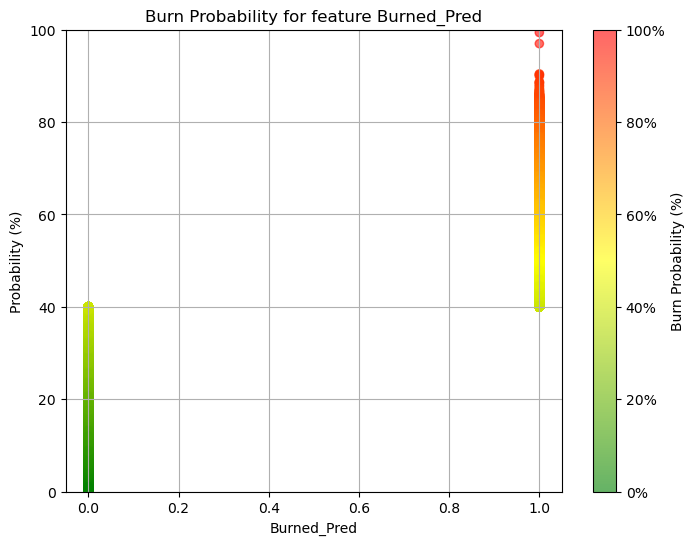

In [21]:
# Define a green-yellow-red colormap
cmap = mcolors.LinearSegmentedColormap.from_list('GreenYellowRed', ['green', 'yellow', 'red'])

# Set fixed range for target values (0 to 100%)
vmin, vmax = 0, 100

# Create a scatter plot for each feature
for feature in features:
    plt.figure(figsize=(8, 6))

    # Scale target to 0-100 for consistent plotting
    target_scaled = target * 100

    # Scatter plot colored by the target variable
    scatter = plt.scatter(features[feature], target_scaled, c=target_scaled, cmap=cmap, alpha=0.6, vmin=vmin, vmax=vmax)

    # Add labels and title
    plt.xlabel(feature)
    plt.ylabel("Probability (%)")
    plt.title(f'Burn Probability for feature {feature}')

    # Add colorbar legend with fixed scale and consistent colormap
    cbar = plt.colorbar(scatter)  # Ensure the colorbar uses the same scatter object
    cbar.set_label('Burn Probability (%)')
    cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))
    cbar.set_ticks(np.linspace(vmin, vmax, 6))  # Ensure ticks span 0% to 100%

    # Set consistent y-axis limits (0 to 100%)
    plt.ylim(vmin, vmax)

    # Add grid
    plt.grid(True)

    # Show plot
    plt.show()

In [18]:
df_original_20231001_results = df_original_20231001[['point_ID', 'POINT_X', 'POINT_Y', 'POINT_Z', 'RF_Prob', 'XGB_Prob', 'MLP_Prob', 'Burned']]

In [23]:
# Set Pandas display option to avoid scientific notation
pd.set_option('display.float_format', '{:.6f}'.format)

# Now run your describe function again
df_original_20231001_results.describe(include='all').T

count            mean            std            min  \
point_ID 24027573.000000 12093269.728403 6998748.939360       1.000000   
POINT_X  24027573.000000   -14369.519098   28539.151552  -77071.323672   
POINT_Y  24027573.000000  -242311.729609   29328.241353 -301405.439807   
POINT_Z  24027573.000000        0.000000       0.000000       0.000000   
RF_Prob  24027573.000000        0.250459       0.116957       0.014679   
XGB_Prob 24027573.000000        0.305916       0.059294       0.236248   
MLP_Prob 24027573.000000        0.233240       0.149692       0.000000   
Burned   24027573.000000        0.000123       0.011085       0.000000   

                    25%             50%             75%             max  
point_ID 6027053.000000 12077698.000000 18155442.000000 24480283.000000  
POINT_X   -38744.045818   -13580.112054    10759.131760    33609.515388  
POINT_Y  -267683.167778  -242729.790493  -216910.935383  -190772.794809  
POINT_Z        0.000000        0.000000        0.000000        0.000000  
RF_Prob        0.157189        0.224502        0.364812        0.453133  
XGB_Prob       0.268689        0.300052        0.345597        0.449935  
MLP_Prob       0.111374        0.183812        0.330573        0.993612  
Burned         0.000000        0.000000        0.000000        1.000000

In [19]:
# Group by 'COS18n1_L' and calculate the percentages using agg
result = df_original_20231001.groupby('COS18n1_L').agg(
    Burned_Percentage=('Burned', lambda x: (x.sum() / len(x)) * 100),  # Percentage of records actually burned
    RF_Prob=('RF_Prob', calculate_percentage),
    XGB_Prob=('XGB_Prob', calculate_percentage),
    MLP_Prob=('MLP_Prob', calculate_percentage),
    Total_Count=('point_ID', 'size'),
)

# Calculate Dataset percentage
total_records = len(df_original_20231001)
result['Dataset_Percentage'] = (result['Total_Count'] / total_records) * 100

result

Burned_Percentage    RF_Prob  \
COS18n1_L                                                                  
Agricultura                                          0.000397   2.721373   
Espaços descobertos ou com pouca vegetação           0.000000   1.028822   
Florestas                                            0.004090  32.407829   
Massas de água superficiais                          0.000000   0.701386   
Matos                                                0.080617  23.432416   
Pastagens                                            0.000000   0.628023   
Superfícies agroflorestais (SAF)                     0.000000   1.745015   
Territórios artificializados                         0.000000   0.854293   
Zonas húmidas                                        0.000000   0.000000   

                                            XGB_Prob   MLP_Prob  Total_Count  \
COS18n1_L                                                                      
Agricultura                                 0.030837   0.976169      5788549   
Espaços descobertos ou com pouca vegetação  0.107169   1.385632        79314   
Florestas                                   0.255307  35.874812      8459604   
Massas de água superficiais                 0.000101   1.038095       994032   
Matos                                       0.074158  27.894402      3205299   
Pastagens                                   0.000130   0.635982      2311859   
Superfícies agroflorestais (SAF)            0.000484   1.912208      2274020   
Territórios artificializados                0.013044   0.569573       758990   
Zonas húmidas                               0.000000  12.790399       155906   

                                            Dataset_Percentage  
COS18n1_L                                                       
Agricultura                                          24.091276  
Espaços descobertos ou com pouca vegetação            0.330096  
Florestas                                            35.207901  
Massas de água superficiais                           4.137047  
Matos                                                13.340086  
Pastagens                                             9.621692  
Superfícies agroflorestais (SAF)                      9.464210  
Territórios artificializados                          3.158829  
Zonas húmidas                                         0.648863

In [25]:
df_original_20231001_results.to_csv('df_original_20231001_results_V2.csv')

# 3: Results

In [27]:
# Load variables from pickle files
with open('rf_metrics_20230511.pkl', 'rb') as f:
    rf_metrics_20230511 = pickle.load(f)

with open('xgb_metrics_20230511.pkl', 'rb') as f:
    xgb_metrics_20230511 = pickle.load(f)

with open('mlp_metrics_20230511.pkl', 'rb') as f:
    mlp_metrics_20230511 = pickle.load(f)

In [24]:
# Load variables from pickle files
with open('rf_metrics_20230723.pkl', 'rb') as f:
    rf_metrics_20230723 = pickle.load(f)

with open('xgb_metrics_20230723.pkl', 'rb') as f:
    xgb_metrics_20230723 = pickle.load(f)

with open('mlp_metrics_20230723.pkl', 'rb') as f:
    mlp_metrics_20230723 = pickle.load(f)

In [25]:
# Load variables from pickle files
with open('rf_metrics_20230802.pkl', 'rb') as f:
    rf_metrics_20230802 = pickle.load(f)

with open('xgb_metrics_20230802.pkl', 'rb') as f:
    xgb_metrics_20230802 = pickle.load(f)

with open('mlp_metrics_20230802.pkl', 'rb') as f:
    mlp_metrics_20230802 = pickle.load(f)

In [28]:
# Load variables from pickle files
with open('rf_metrics_20230807.pkl', 'rb') as f:
    rf_metrics_20230807 = pickle.load(f)

with open('xgb_metrics_20230807.pkl', 'rb') as f:
    xgb_metrics_20230807 = pickle.load(f)

with open('mlp_metrics_20230807.pkl', 'rb') as f:
    mlp_metrics_20230807 = pickle.load(f)

In [29]:
# Load variables from pickle files
with open('rf_metrics_20231001.pkl', 'rb') as f:
    rf_metrics_20231001 = pickle.load(f)

with open('xgb_metrics_20231001.pkl', 'rb') as f:
    xgb_metrics_20231001 = pickle.load(f)

with open('mlp_metrics_20231001.pkl', 'rb') as f:
    mlp_metrics_20231001 = pickle.load(f)

In [38]:
# Combine all metrics into a list of dictionaries
results_subset_1 = [
    {'Model': 'Random Forest', 'Table': '20230511', **rf_metrics_20230511},
    {'Model': 'XGBoost', 'Table': '20230511', **xgb_metrics_20230511},
    {'Model': 'MLP', 'Table': '20230511', **mlp_metrics_20230511},
    {'Model': 'Random Forest', 'Table': '20230807', **rf_metrics_20230807},
    {'Model': 'XGBoost', 'Table': '20230807', **xgb_metrics_20230807},
    {'Model': 'MLP', 'Table': '20230807', **mlp_metrics_20230807},
    {'Model': 'Random Forest', 'Table': '20231001', **rf_metrics_20231001},
    {'Model': 'XGBoost', 'Table': '20231001', **xgb_metrics_20231001},
    {'Model': 'MLP', 'Table': '20231001', **mlp_metrics_20231001},
]

# Create a DataFrame from the results
results_df_subset_1 = pd.DataFrame(results_subset_1)

# Add true number of target=0 and target=1 for each model
results_df_subset_1['Target=1 (TP + FN)'] = results_df_subset_1['True Positives (TP)'] + results_df_subset_1['False Negatives (FN)']
results_df_subset_1['Target=0 (TN + FP)'] = results_df_subset_1['True Negatives (TN)'] + results_df_subset_1['False Positives (FP)']

# Display the DataFrame
print("Individual Results Across Tables and Models:")
results_df_subset_1

Individual Results Across Tables and Models:


Model     Table  Accuracy  Balanced Accuracy  Recall (Sensitivity)  \
0  Random Forest  20230511  0.936555           0.469493              0.001467   
1        XGBoost  20230511  0.997903           0.499466              0.000000   
2            MLP  20230511  0.932716           0.466839              0.000000   
3  Random Forest  20230807  0.883389           0.455080              0.026604   
4        XGBoost  20230807  0.991932           0.496062              0.000000   
5            MLP  20230807  0.894806           0.462183              0.029393   
6  Random Forest  20231001  0.845170           0.543516              0.241788   
7        XGBoost  20231001  0.998797           0.499460              0.000000   
8            MLP  20231001  0.830196           0.611535              0.392821   

   Precision  F1-Score  ROC-AUC  Matthews Correlation Coefficient (MCC)  \
0   0.000024  0.000048 0.371733                               -0.008090   
1   0.000000  0.000000 0.479126                               -0.001050   
2   0.000000  0.000000 0.463965                               -0.008553   
3   0.000044  0.000089 0.506466                               -0.003901   
4   0.000000  0.000000 0.654955                               -0.001241   
5   0.000054  0.000108 0.640846                               -0.003436   
6   0.000192  0.000384 0.690739                                0.002668   
7   0.000000  0.000000 0.699493                               -0.000365   
8   0.000284  0.000568 0.752291                                0.006587   

   True Positives (TP)  False Positives (FP)  True Negatives (TN)  \
0                   12                495836              7439928   
1                    0                  8480              7927284   
2                    0                526318              7409446   
3                  124               2797290             21225211   
4                    0                189187             23833314   
5                  137               2522996             21499505   
6                  714               3717940             20306680   
7                    0                 25959             23998661   
8                 1160               4078181             19946439   

   False Negatives (FN)  Support (Total Positive)  Support (Total Negative)  \
0                  8170                      8182                   7935764   
1                  8182                      8182                   7935764   
2                  8182                      8182                   7935764   
3                  4537                      4661                  24022501   
4                  4661                      4661                  24022501   
5                  4524                      4661                  24022501   
6                  2239                      2953                  24024620   
7                  2953                      2953                  24024620   
8                  1793                      2953                  24024620   

   Target=1 (TP + FN)  Target=0 (TN + FP)  
0                8182             7935764  
1                8182             7935764  
2                8182             7935764  
3                4661            24022501  
4                4661            24022501  
5                4661            24022501  
6                2953            24024620  
7                2953            24024620  
8                2953            24024620

In [39]:
# Aggregate the results by summing confusion matrix components across tables
aggregated_results_subset_1 = results_df_subset_1.groupby('Model').agg({
    'True Positives (TP)': 'sum',
    'True Negatives (TN)': 'sum',
    'False Positives (FP)': 'sum',
    'False Negatives (FN)': 'sum',
    'Target=1 (TP + FN)': 'sum',
    'Target=0 (TN + FP)': 'sum'
}).reset_index()

# Recalculate aggregated metrics
aggregated_results_subset_1['Accuracy'] = (aggregated_results_subset_1['True Positives (TP)'] + aggregated_results_subset_1['True Negatives (TN)']) / (
    aggregated_results_subset_1['True Positives (TP)'] + aggregated_results_subset_1['True Negatives (TN)'] +
    aggregated_results_subset_1['False Positives (FP)'] + aggregated_results_subset_1['False Negatives (FN)']
)
aggregated_results_subset_1['Recall'] = aggregated_results_subset_1['True Positives (TP)'] / (
    aggregated_results_subset_1['True Positives (TP)'] + aggregated_results_subset_1['False Negatives (FN)']
)
aggregated_results_subset_1['Precision'] = aggregated_results_subset_1['True Positives (TP)'] / (
    aggregated_results_subset_1['True Positives (TP)'] + aggregated_results_subset_1['False Positives (FP)']
)
aggregated_results_subset_1['F1-Score'] = 2 * (aggregated_results_subset_1['Precision'] * aggregated_results_subset_1['Recall']) / (
    aggregated_results_subset_1['Precision'] + aggregated_results_subset_1['Recall']
)

# Display the aggregated results
print("\nAggregated Results Across All Tables:")
aggregated_results_subset_1


Aggregated Results Across All Tables:


Model  True Positives (TP)  True Negatives (TN)  \
0            MLP                 1297             48855390   
1  Random Forest                  850             48971819   
2        XGBoost                    0             55759259   

   False Positives (FP)  False Negatives (FN)  Target=1 (TP + FN)  \
0               7127495                 14499               15796   
1               7011066                 14946               15796   
2                223626                 15796               15796   

   Target=0 (TN + FP)  Accuracy  Recall (Sensitivity)  Precision  F1-Score  
0            55982885  0.872461              0.082109   0.000182  0.000363  
1            55982885  0.874533              0.053811   0.000121  0.000242  
2            55982885  0.995725              0.000000   0.000000       NaN

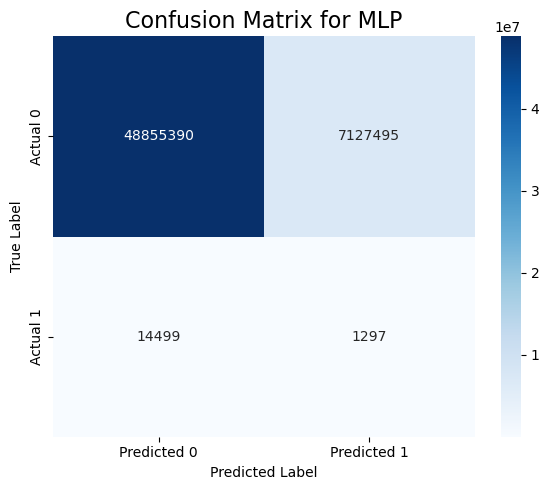

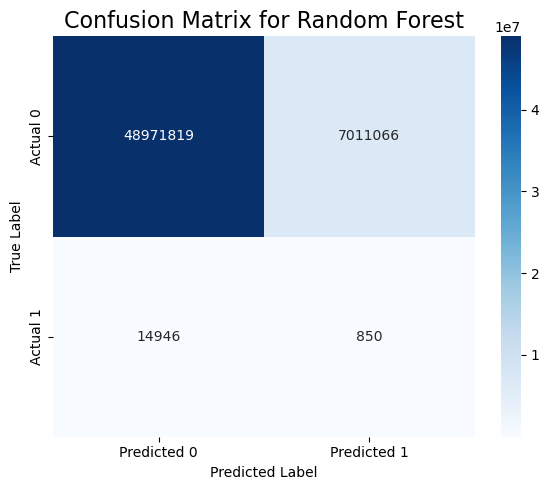

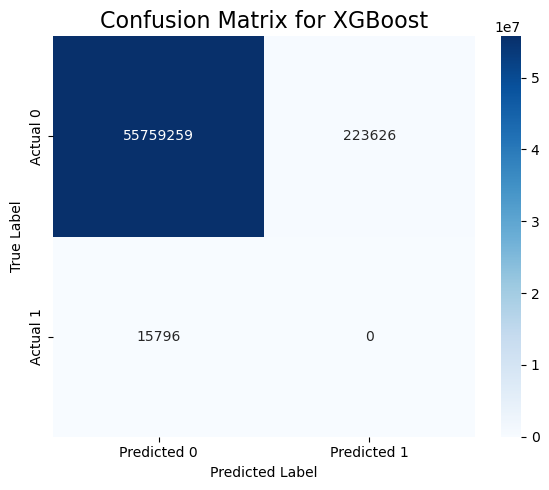

In [40]:
for model in aggregated_results_subset_1['Model']:
    plot_confusion_matrix_from_aggregated_results(model, aggregated_results_subset_1)

In [28]:
# Combine all metrics into a list of dictionaries
results_subset_2 = [
    {'Model': 'Random Forest', 'Table': '20230723', **rf_metrics_20230723},
    {'Model': 'XGBoost', 'Table': '20230723', **xgb_metrics_20230723},
    {'Model': 'MLP', 'Table': '20230723', **mlp_metrics_20230723},
    {'Model': 'Random Forest', 'Table': '20230802', **rf_metrics_20230802},
    {'Model': 'XGBoost', 'Table': '20230802', **xgb_metrics_20230802},
    {'Model': 'MLP', 'Table': '20230802', **mlp_metrics_20230802},
]

# Create a DataFrame from the results
results_df_subset_2 = pd.DataFrame(results_subset_2)

# Add true number of target=0 and target=1 for each model
results_df_subset_2['Target=1 (TP + FN)'] = results_df_subset_2['True Positives (TP)'] + results_df_subset_2['False Negatives (FN)']
results_df_subset_2['Target=0 (TN + FP)'] = results_df_subset_2['True Negatives (TN)'] + results_df_subset_2['False Positives (FP)']

# Display the DataFrame
print("Individual Results Across Tables and Models:")
results_df_subset_2

Individual Results Across Tables and Models:


Model     Table  Accuracy  Balanced Accuracy   Recall  Precision  \
0  Random Forest  20230723  0.785308           0.526853 0.268311   0.000211   
1        XGBoost  20230723  0.894885           0.514584 0.134155   0.000216   
2            MLP  20230723  0.999831           0.500000 0.000000   0.000000   
3  Random Forest  20230802  0.797054           0.679623 0.560324   0.021504   
4        XGBoost  20230802  0.898893           0.564076 0.223936   0.018104   
5            MLP  20230802  0.992175           0.500000 0.000000   0.000000   

   F1-Score  ROC-AUC  Matthews Correlation Coefficient (MCC)  \
0  0.000422 0.675225                                0.001699   
1  0.000431 0.712953                                0.001236   
2  0.000000 0.624705                                0.000000   
3  0.041419 0.750761                                0.078567   
4  0.033500 0.705636                                0.038190   
5  0.000000 0.790410                                0.000000   

   True Positives (TP)  False Positives (FP)  True Negatives (TN)  \
0                 1088               5155470             18867637   
1                  544               2522105             21501002   
2                    0                     0             24023107   
3               105346               4793547             19045606   
4                42102               2283412             21555741   
5                    0                     0             23839153   

   False Negatives (FN)  Support (Total Positive)  Support (Total Negative)  \
0                  2967                      4055                  24023107   
1                  3511                      4055                  24023107   
2                  4055                      4055                  24023107   
3                 82663                    188009                  23839153   
4                145907                    188009                  23839153   
5                188009                    188009                  23839153   

   Target=1 (TP + FN)  Target=0 (TN + FP)  
0                4055            24023107  
1                4055            24023107  
2                4055            24023107  
3              188009            23839153  
4              188009            23839153  
5              188009            23839153

In [29]:
# Aggregate the results by summing confusion matrix components across tables
aggregated_results_subset_2 = results_df_subset_2.groupby('Model').agg({
    'True Positives (TP)': 'sum',
    'True Negatives (TN)': 'sum',
    'False Positives (FP)': 'sum',
    'False Negatives (FN)': 'sum',
    'Target=1 (TP + FN)': 'sum',
    'Target=0 (TN + FP)': 'sum'
}).reset_index()

# Recalculate aggregated metrics
aggregated_results_subset_2['Accuracy'] = (aggregated_results_subset_2['True Positives (TP)'] + aggregated_results_subset_2['True Negatives (TN)']) / (
    aggregated_results_subset_2['True Positives (TP)'] + aggregated_results_subset_2['True Negatives (TN)'] +
    aggregated_results_subset_2['False Positives (FP)'] + aggregated_results_subset_2['False Negatives (FN)']
)
aggregated_results_subset_2['Recall'] = aggregated_results_subset_2['True Positives (TP)'] / (
    aggregated_results_subset_2['True Positives (TP)'] + aggregated_results_subset_2['False Negatives (FN)']
)
aggregated_results_subset_2['Precision'] = aggregated_results_subset_2['True Positives (TP)'] / (
    aggregated_results_subset_2['True Positives (TP)'] + aggregated_results_subset_2['False Positives (FP)']
)
aggregated_results_subset_2['F1-Score'] = 2 * (aggregated_results_subset_2['Precision'] * aggregated_results_subset_2['Recall']) / (
    aggregated_results_subset_2['Precision'] + aggregated_results_subset_2['Recall']
)

# Display the aggregated results
print("\nAggregated Results Across All Tables:")
aggregated_results_subset_2


Aggregated Results Across All Tables:


Model  True Positives (TP)  True Negatives (TN)  \
0            MLP                    0             47862260   
1  Random Forest               106434             37913243   
2        XGBoost                42646             43056743   

   False Positives (FP)  False Negatives (FN)  Target=1 (TP + FN)  \
0                     0                192064              192064   
1               9949017                 85630              192064   
2               4805517                149418              192064   

   Target=0 (TN + FP)  Accuracy   Recall  Precision  F1-Score  
0            47862260  0.996003 0.000000        NaN       NaN  
1            47862260  0.791181 0.554159   0.010585  0.020773  
2            47862260  0.896889 0.222041   0.008796  0.016922

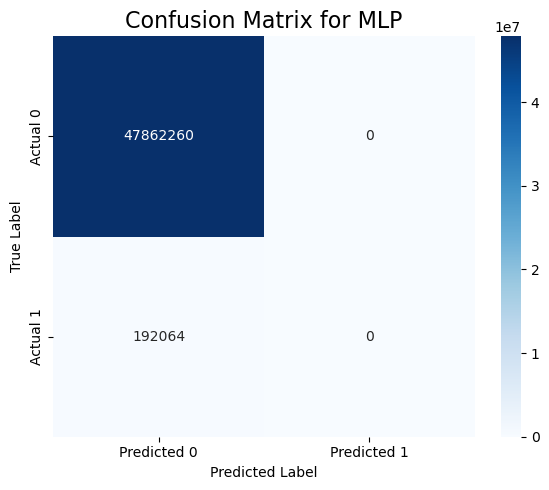

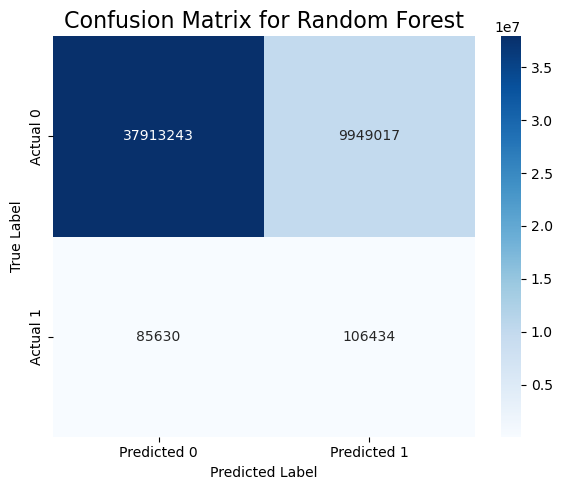

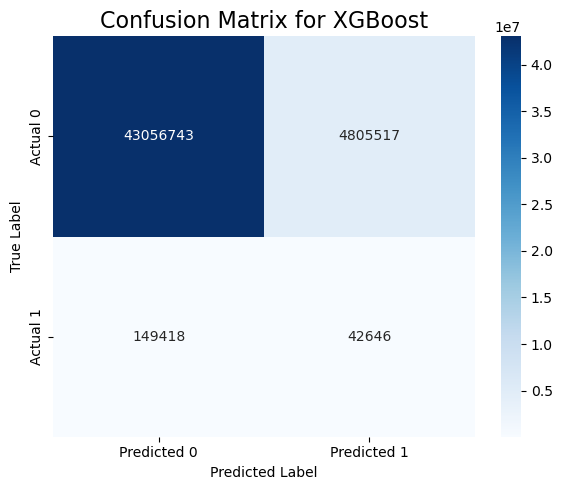

In [31]:
for model in aggregated_results_subset_2['Model']:
    plot_confusion_matrix_from_aggregated_results(model, aggregated_results_subset_2)